## Final Project - Learning From Recessions




In [9]:
from course import *
import pandas_datareader as pdr
import numpy as np

from numpy import linalg
from numpy.linalg import inv
from fredapi import Fred
from scipy import signal
import datetime
import pandas as pd
import matplotlib.pyplot as plt

## STEP 1. Download, Transform, and Plot Data

### STEP 1.1 Download

Create one pandas dataframe containing the following FRED times series:
- Quarterly dates
- (r_t): NBER recession dates (=1 if recession, 0 otherwise)
- (y_{1t}... y_{nt}): observable economic variables

In [10]:
# Download datasets as pandas dataframe
# (r_t): NBER recession dates (quarterly)
USRECQ = pdr.DataReader("USRECQ", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real personal income excluding current transfer receipts (quarterly)
PIECTR = pdr.DataReader("PIECTR", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real personal consumption expenditures (quarterly)
PCECC96 = pdr.DataReader("PCECC96", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real GDP (quarterly)
GDPC1 = pdr.DataReader("GDPC1", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real GDI (quarterly)
A261RX1Q020SBEA = pdr.DataReader("A261RX1Q020SBEA", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real Average GDP and GDI (quarterly)
LB0000091Q020SBEA = pdr.DataReader("LB0000091Q020SBEA", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# All Employees, Total Nonfarm (monthly)
PAYEMS = pdr.DataReader("PAYEMS", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Employment Level (monthly)
CE16OV = pdr.DataReader("CE16OV", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Industrial production total index (monthly)
INDPRO = pdr.DataReader("INDPRO", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real Manufacturing and Trade Industries Sales, adjusted for price changes (monthly)
CMRMTSPL = pdr.DataReader("CMRMTSPL", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# create dataframe for quarterly variables
df_quarterly = pd.concat([USRECQ, PIECTR, PCECC96, GDPC1, A261RX1Q020SBEA, LB0000091Q020SBEA],axis=1,join="inner")
df_quarterly = df_quarterly.reset_index()
df_quarterly['DATE'] = pd.to_datetime(df_quarterly['DATE'])
df_quarterly = df_quarterly.groupby(df_quarterly['DATE'].dt.to_period('Q')).sum()
# convert monthly datasets into quarterly
# create dataframe for monthly variables
df_monthly = pd.concat([PAYEMS, CE16OV, INDPRO, CMRMTSPL],axis=1,join="inner")
df_monthly = df_monthly.reset_index()
df_monthly['DATE'] = pd.to_datetime(df_monthly['DATE'])
# convert into quarterly averages
df_new = df_monthly.groupby(df_monthly['DATE'].dt.to_period('Q')).mean().round()
# merge dataframes together
df = pd.concat([df_quarterly, df_new],axis=1,join="inner")
# rename columns to readable names
df = df.rename(columns={"USRECQ": "nber_recessions",
                        "PIECTR": "real_personal_income_less_transfers",
                        "PCECC96": "real_pce",
                        "GDPC1": "real_gdp",
                        "A261RX1Q020SBEA": "real_gdi",
                        "LB0000091Q020SBEA": "real_avg_gdp_gdi",
                        "PAYEMS": "total_nonfarm_emp",
                        "CE16OV": "emp_level",
                        "INDPRO": "industrial_prod_index",
                        "CMRMTSPL": "real_manuf_trade_sales"})
# look at our pretty dataframe
# df.head()

/var/folders/rn/gpyr2lh10l3c5ddvt9swp_3h0000gn/T/ipykernel_98321/3055280550.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_quarterly = df_quarterly.groupby(df_quarterly['DATE'].dt.to_period('Q')).sum()
/var/folders/rn/gpyr2lh10l3c5ddvt9swp_3h0000gn/T/ipykernel_98321/3055280550.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new = df_monthly.groupby(df_monthly['DATE'].dt.to_period('Q')).mean().round()


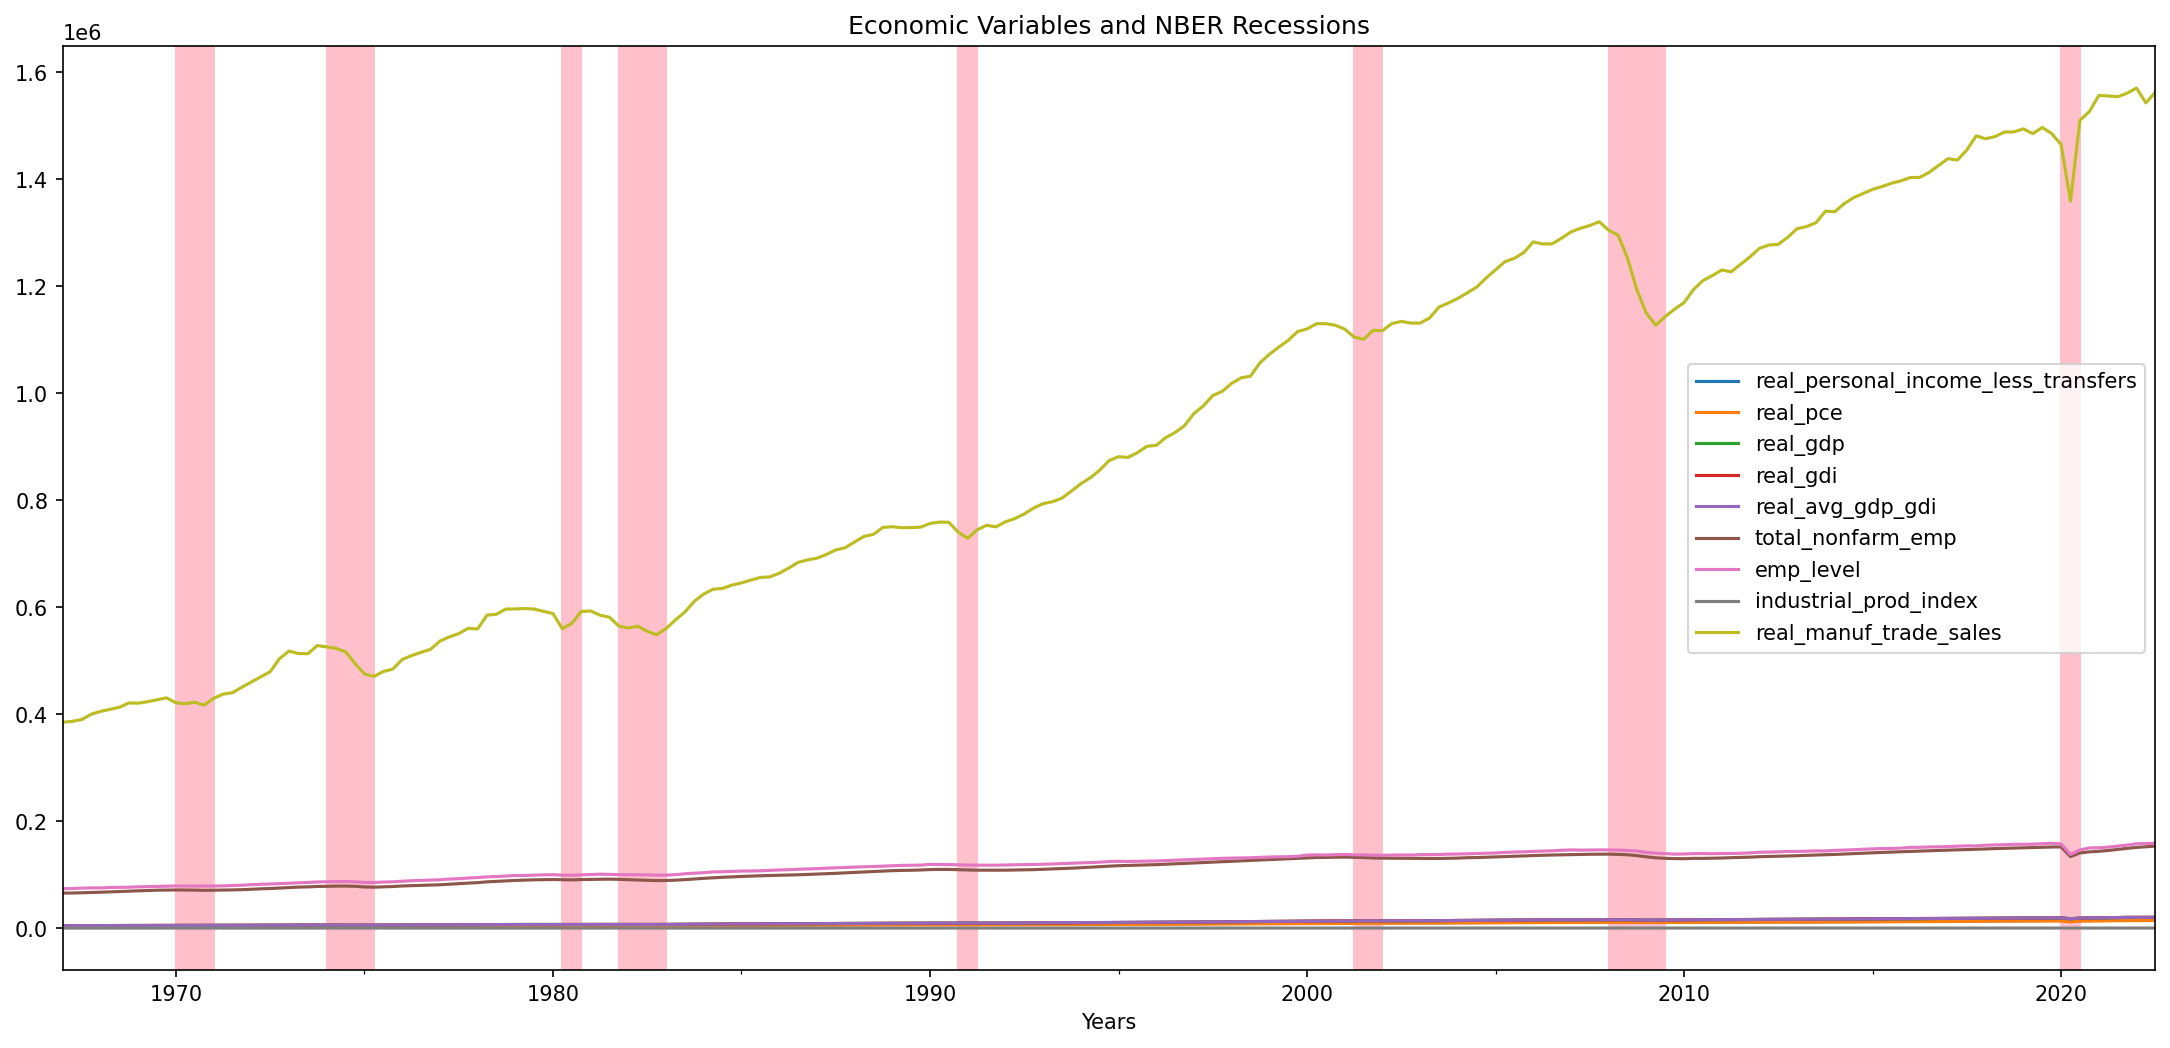

In [11]:
# Plot everything so we know what we're dealing with
plt.figure(figsize=(18, 8), dpi=150)
df['real_personal_income_less_transfers'].plot(label='real_personal_income_less_transfers')
df['real_pce'].plot(label='real_pce')
df['real_gdp'].plot(label='real_gdp')
df['real_gdi'].plot(label='real_gdi')
df['real_avg_gdp_gdi'].plot(label='real_avg_gdp_gdi')
df['total_nonfarm_emp'].plot(label='total_nonfarm_emp')
df['emp_level'].plot(label='emp_level')
df['industrial_prod_index'].plot(label='industrial_prod_index')
df['real_manuf_trade_sales'].plot(label='real_manuf_trade_sales')

# adding title to the plot
plt.title('Economic Variables and NBER Recessions')
  
# adding Label to the x-axis
plt.xlabel('Years')

# Adding shaded recessions
ilist = list(range(len(df['nber_recessions'])))
for i in range(len(df['nber_recessions'])):
    if df['nber_recessions'].iloc[i] == 1:
        plt.axvspan(df.index[i], df.index[i+1], color = 'pink')
        

# adding legend to the curve
plt.legend()
plt.show()

### STEP 1.2 Transform our data to make meaningful comparisons:

For each covariate y_ti, get the quarterly annualized (logarithmic) growth rate

In [12]:
# Compute quarterly annualized (logarithmic) growth rate
df['log_real_personal_income_less_transfers'] = 4*np.log(df['real_personal_income_less_transfers'].pct_change(periods=1) + 1)
df['log_real_pce'] = 4*np.log(df['real_pce'].pct_change(periods=1) + 1)
df['log_real_gdp'] = 4*np.log(df['real_gdp'].pct_change(periods=1) + 1)
df['log_real_gdi'] = 4*np.log(df['real_gdi'].pct_change(periods=1) + 1)
df['log_real_avg_gdp_gdi'] = 4*np.log(df['real_avg_gdp_gdi'].pct_change(periods=1) + 1)
df['log_total_nonfarm_emp'] = 4*np.log(df['total_nonfarm_emp'].pct_change(periods=1) + 1)
df['log_emp_level'] = 4*np.log(df['emp_level'].pct_change(periods=1) + 1)
df['log_industrial_prod_index'] = 4*np.log(df['industrial_prod_index'].pct_change(periods=1) + 1)
df['log_real_manuf_trade_sales'] = 4*np.log(df['real_manuf_trade_sales'].pct_change(periods=1) + 1)

# see our new dataframe
df.head()

df.to_csv('logged_data.csv')


### STEP 1.3 Plot Our New Time Series Data

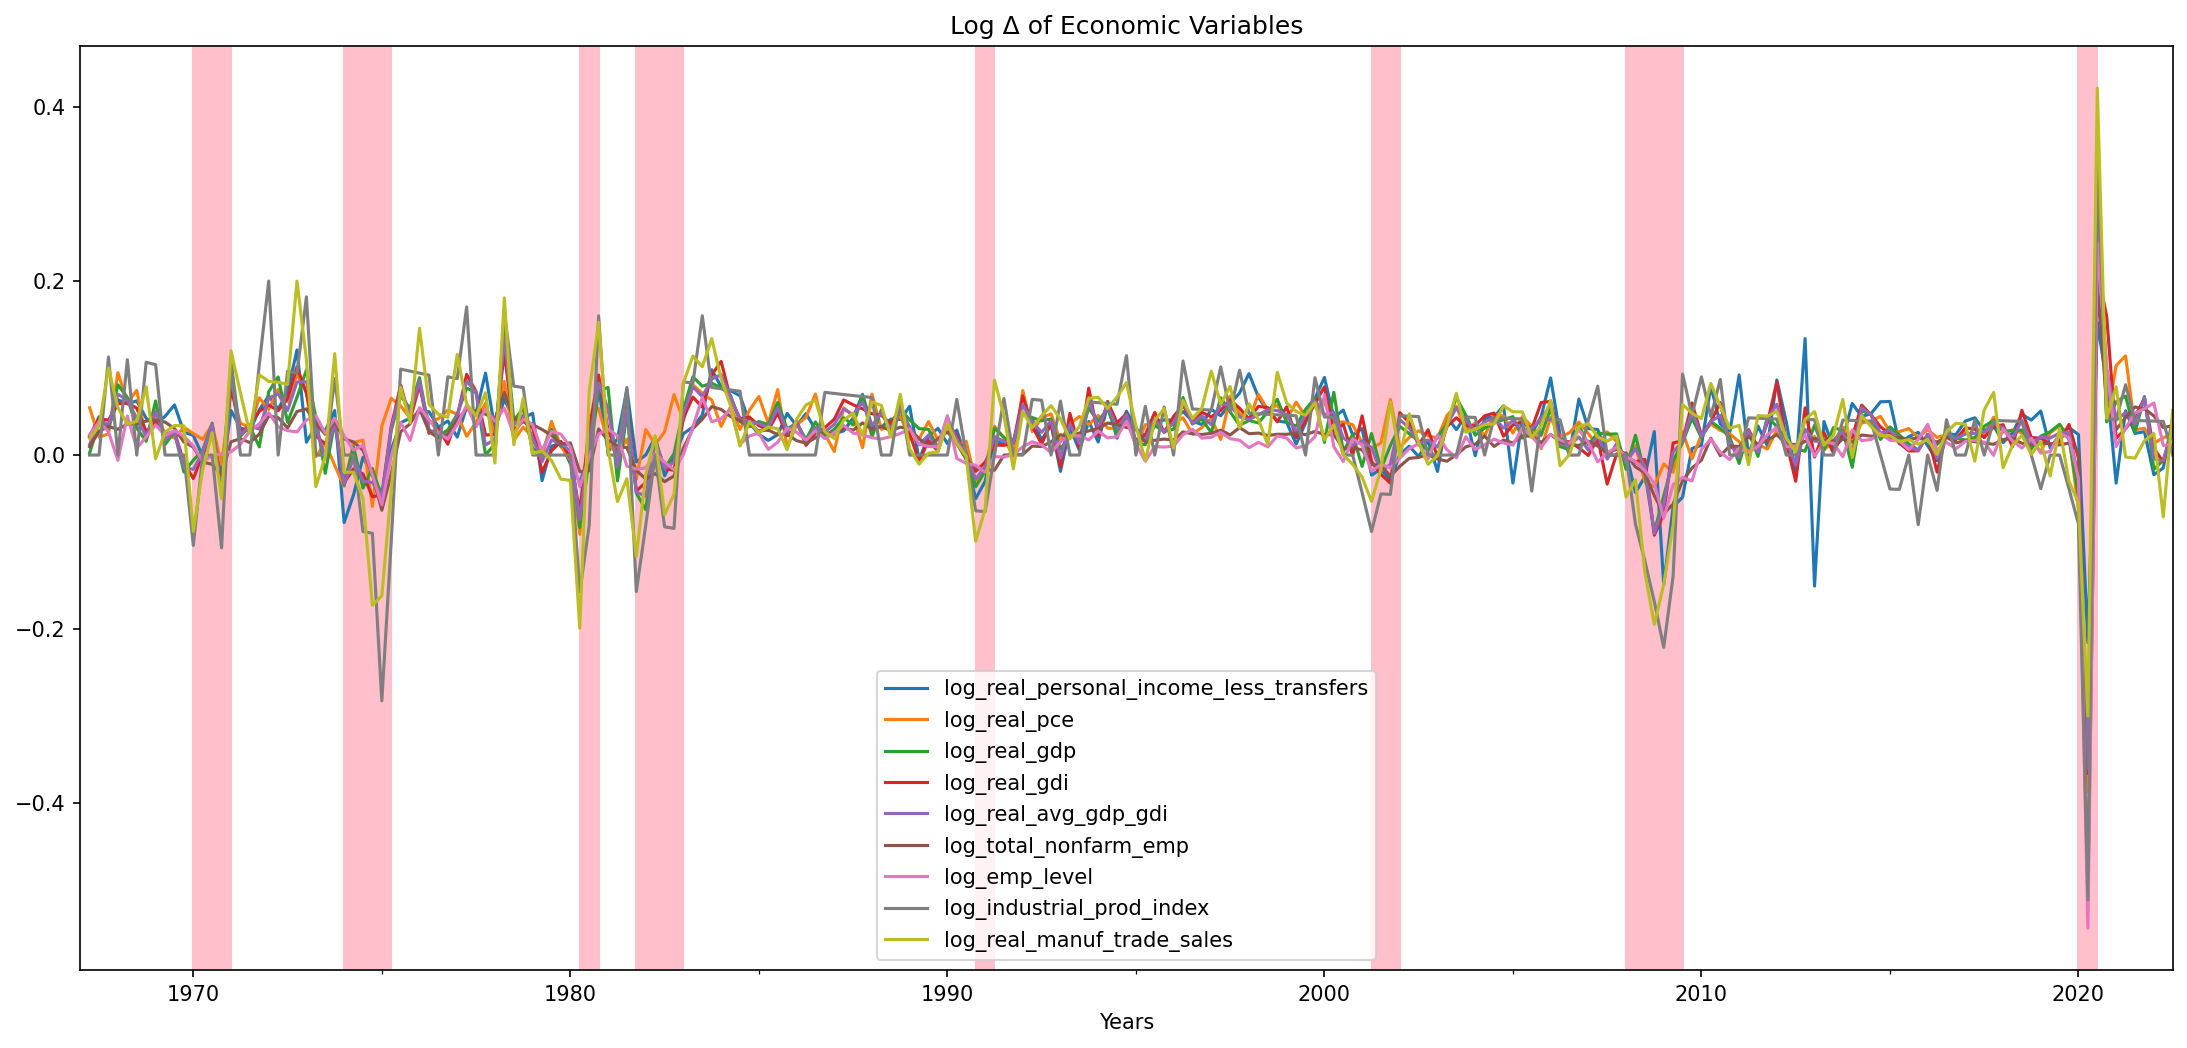

In [13]:
# Plot everything so we know what we're dealing with
plt.figure(figsize=(18, 8), dpi=150)
  
# in plot method we set the label and color of the curve.
# df['nber_recessions'].plot(label='NBER_recessions', color='orange')
df['log_real_personal_income_less_transfers'].plot(label='log_real_personal_income_less_transfers')
df['log_real_pce'].plot(label='log_real_pce')
df['log_real_gdp'].plot(label='log_real_gdp')
df['log_real_gdi'].plot(label='log_real_gdi')
df['log_real_avg_gdp_gdi'].plot(label='log_real_avg_gdp_gdi')
df['log_total_nonfarm_emp'].plot(label='log_total_nonfarm_emp')
df['log_emp_level'].plot(label='log_emp_level')
df['log_industrial_prod_index'].plot(label='log_industrial_prod_index')
df['log_real_manuf_trade_sales'].plot(label='log_real_manuf_trade_sales')

# adding title to the plot
plt.title('Log Δ of Economic Variables')
  
# adding Label to the x-axis
plt.xlabel('Years')

# Adding shaded recessions
ilist = list(range(len(df['nber_recessions'])))
for i in range(len(df['nber_recessions'])):
    if df['nber_recessions'].iloc[i] == 1:
        plt.axvspan(df.index[i], df.index[i+1], color = 'pink')
        
# plt.xlim([0.01, df['nber_recessions'].shape[0]])
  
# adding legend to the curve
plt.legend()
plt.show()

In [14]:
def plot(data, nvar, legend_loc='center right'):
    for i in range(nvar):
        d = np.array( data.T.iloc[[i]].T )
        plt.plot(d)
    plt.legend(data.keys(), loc=legend_loc,prop={'size': 7})

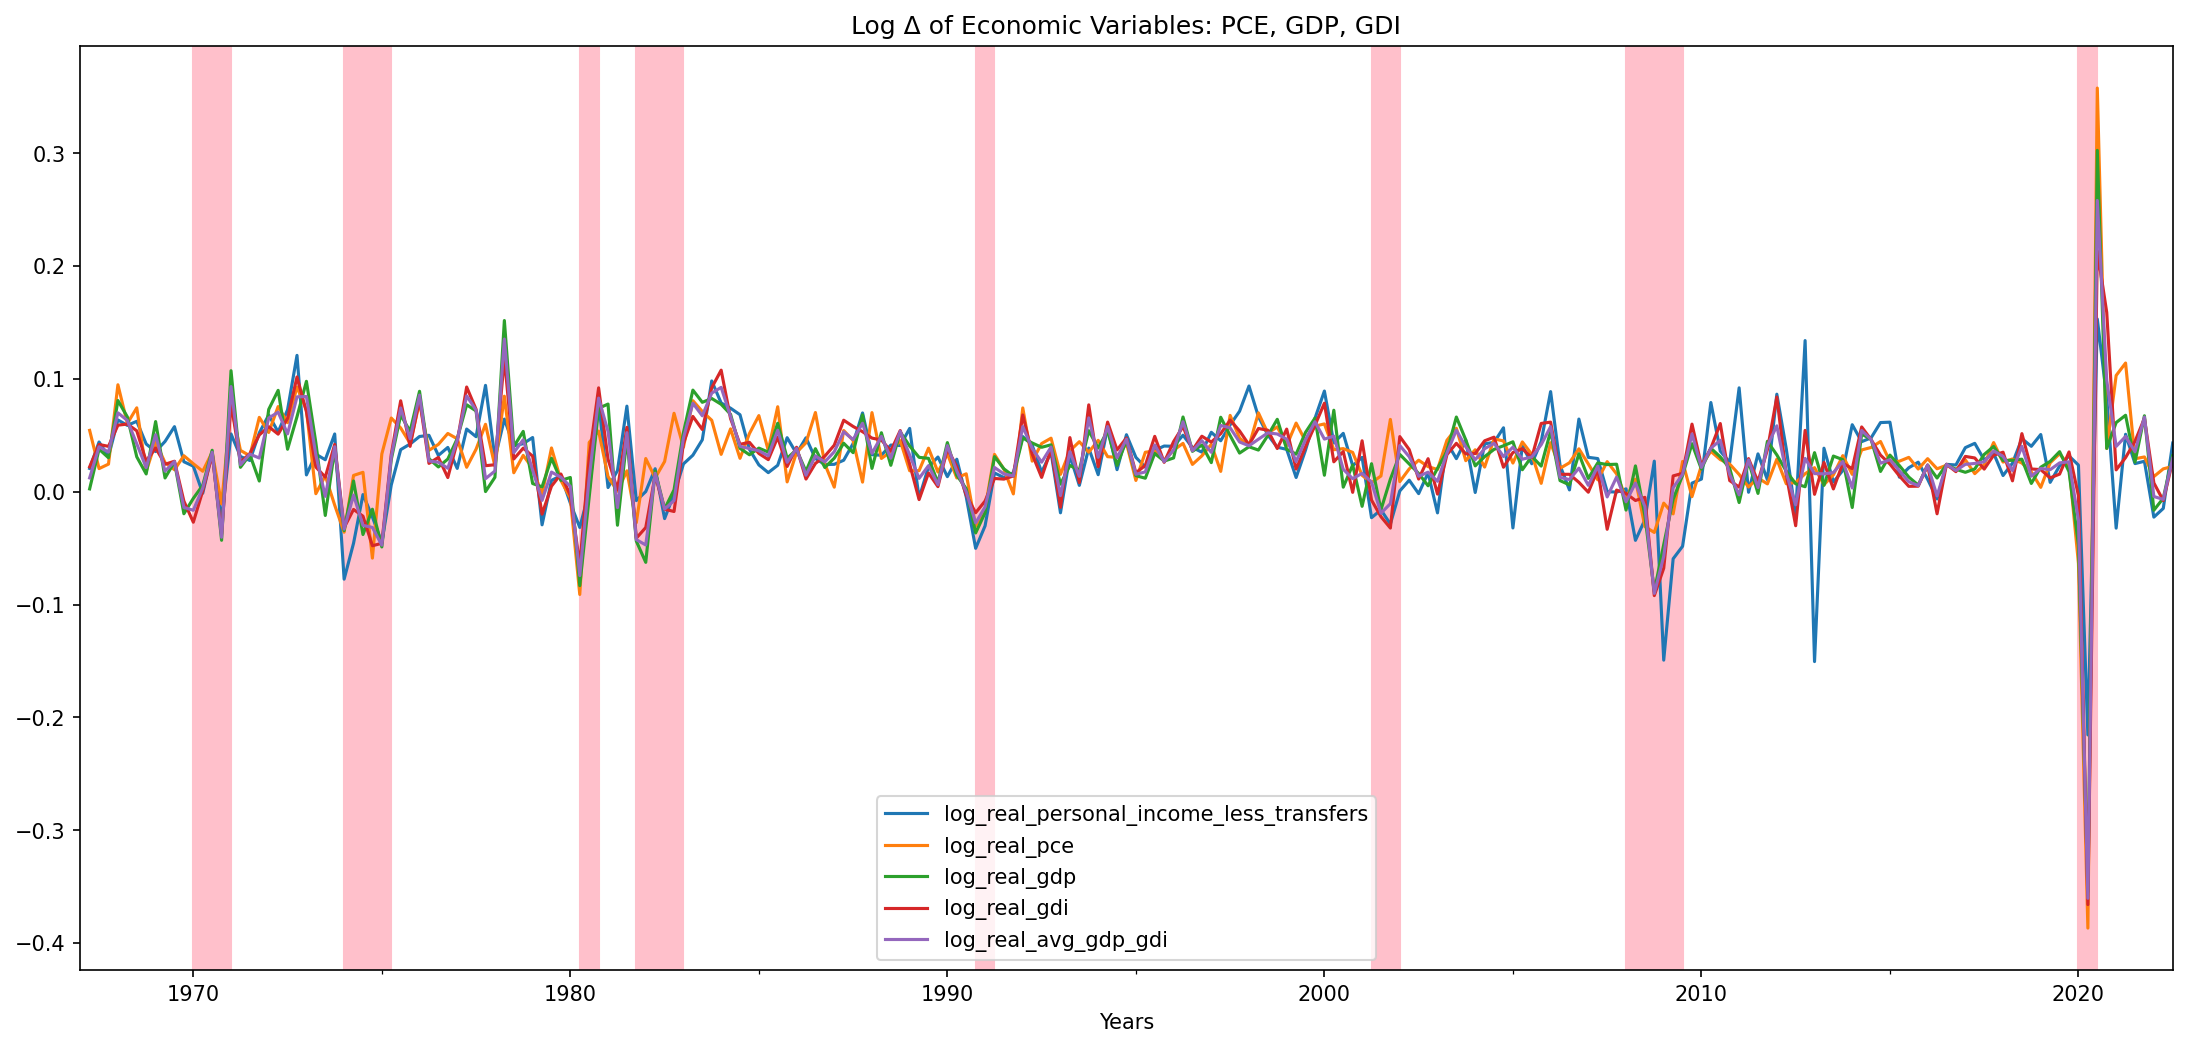

In [15]:
# Plot subsets of covariates
plt.figure(figsize=(18, 8), dpi=150)
  
# in plot method we set the label and color of the curve.
# df['nber_recessions'].plot(label='NBER_recessions', color='orange')
df['log_real_personal_income_less_transfers'].plot(label='log_real_personal_income_less_transfers')
df['log_real_pce'].plot(label='log_real_pce')
df['log_real_gdp'].plot(label='log_real_gdp')
df['log_real_gdi'].plot(label='log_real_gdi')
df['log_real_avg_gdp_gdi'].plot(label='log_real_avg_gdp_gdi')
# df['log_total_nonfarm_emp'].plot(label='log_total_nonfarm_emp')
# df['log_emp_level'].plot(label='log_emp_level')
# df['log_industrial_prod_index'].plot(label='log_industrial_prod_index')
# df['log_real_manuf_trade_sales'].plot(label='log_real_manuf_trade_sales')

# adding title to the plot
plt.title('Log Δ of Economic Variables: PCE, GDP, GDI')
  
# adding Label to the x-axis
plt.xlabel('Years')

# Adding shaded recessions
ilist = list(range(len(df['nber_recessions'])))
for i in range(len(df['nber_recessions'])):
    if df['nber_recessions'].iloc[i] == 1:
        plt.axvspan(df.index[i], df.index[i+1], color = 'pink')

plt.legend()
plt.show()

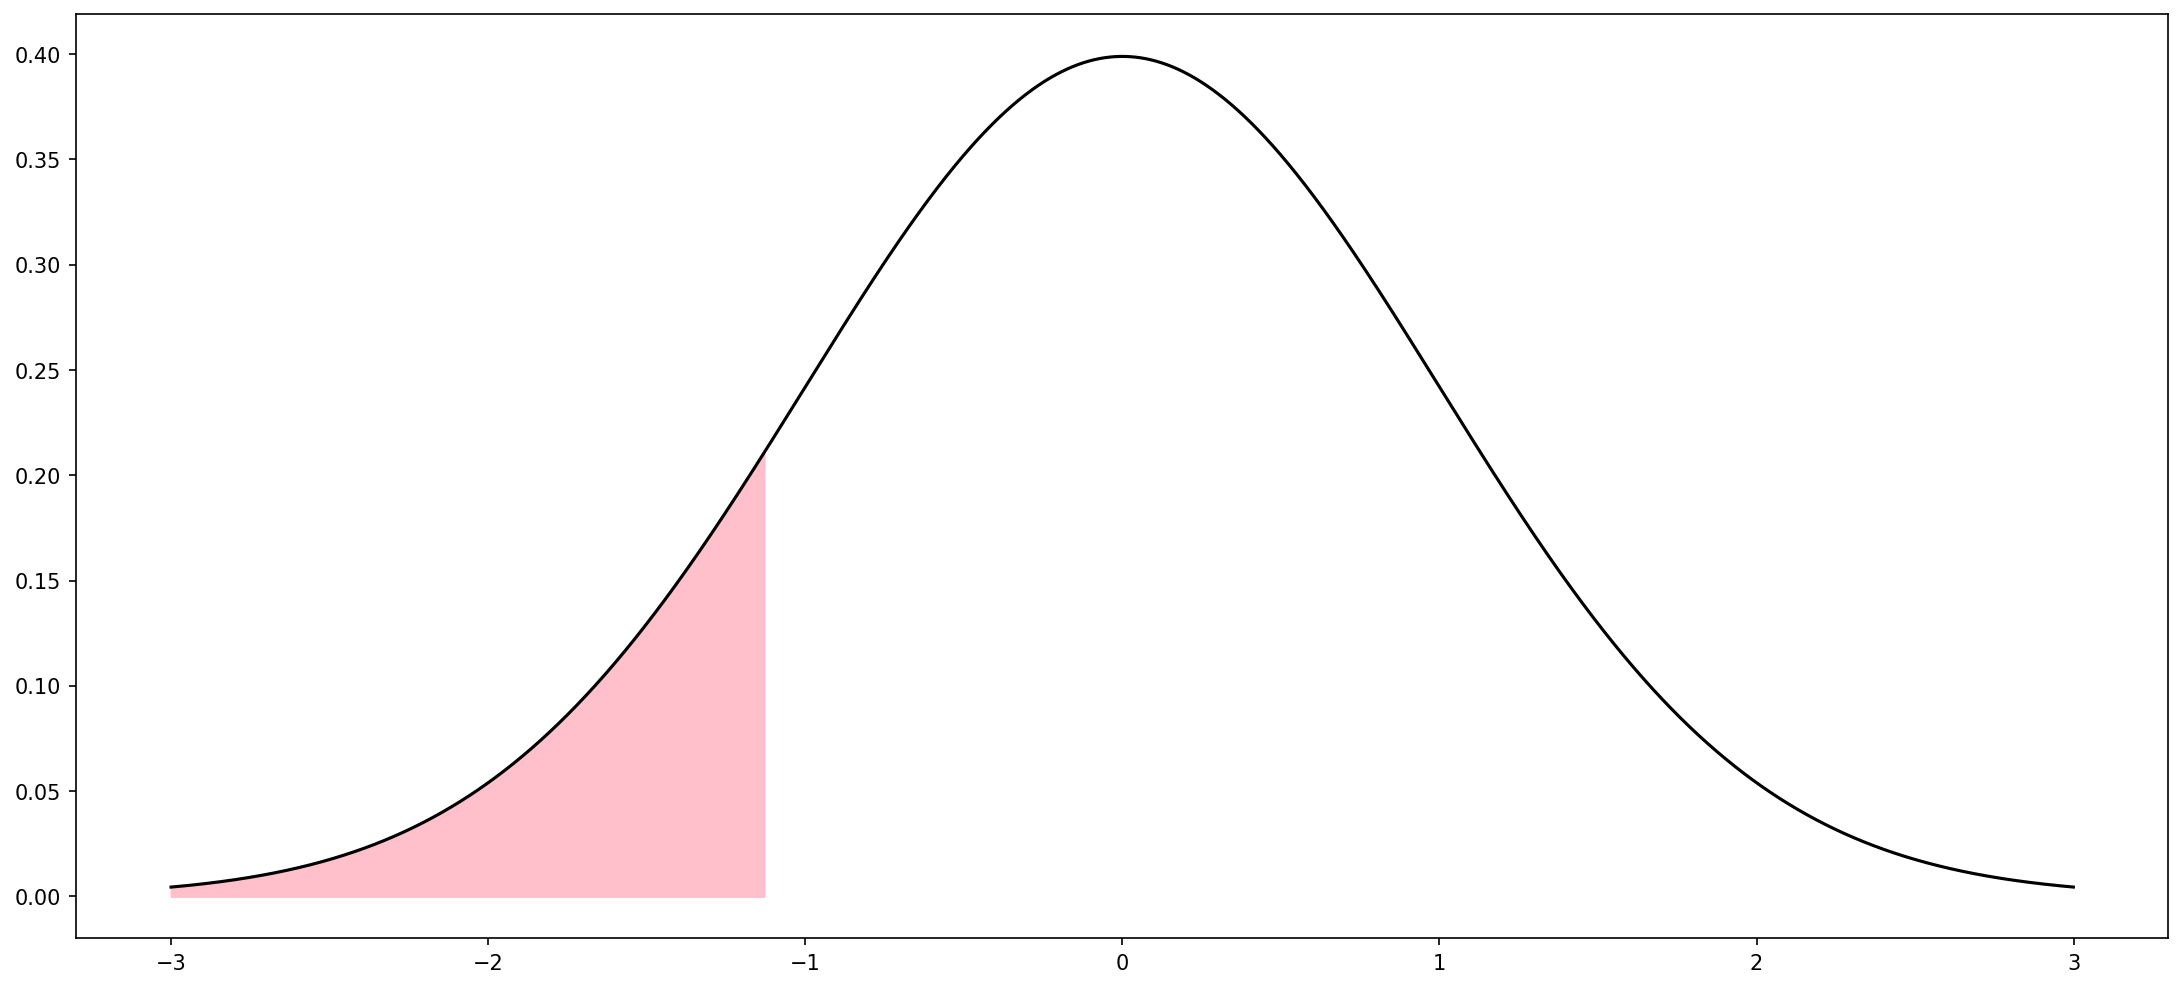

In [16]:
from scipy import stats
from scipy.stats import norm

x = np.arange(-3, 3, 0.001)
plt.figure(figsize=(18, 8), dpi=150)
plt.plot(x, norm.pdf(x, 0, 1), color='black')

px = np.arange(-3, -1.12, 0.01)
plt.fill_between(px, norm.pdf(px), color='pink')
plt.show()

### STEP 2. Use Kalman Filter to get $\hat{x}_t$

In [17]:
import numpy as np
from numpy import linalg

### Declaring class and methods

##### Methods: 
1. ``forecast``: produces $\hat{x}_t, \hat{\Sigma}$ via Kalman filter procedure
2. ``rhat_fn``: produces $\hat{r}_t$ with $R  = \gamma \mathbb{E}[\hat{x}_t]$, where by $\gamma$ is a tuning parameter and by default $\gamma = 0.5$
3. ``plot_fig``: plots estimated $\hat{x}_t$
4. ``calc_err``: calculates sum of absolute differences (and squared by default, since values are either 1 or 0) between true $r_t$ and ``rhat_fn`` output $\hat{r}_t$ 

In [18]:
class Kalman:
    def __init__(self, x0, sigma0, A, C, G, R, y):
        self.x0, self.sigma0 = x0, sigma0
        self.A, self.C, self.G, self.R, self.y = A, C, G, R, y
        
    def forecast(self):
        T = len(y)
        xhat = np.zeros((T,1))
        xhat[0] = self.x0
        sigmahat = np.zeros((T,1))
        sigmahat[0] = self.sigma0
        for t in range(T-1):
            a_t = self.y[t] - self.G@xhat[t]
            K_t = self.A @ sigmahat[t] @ self.G.T @ linalg.inv(( linalg.multi_dot((self.G, sigmahat[t][0])) @ self.G.T) + self.R)
            sigmahat[t+1] = (self.A - K_t @ self.G)@sigmahat[t]@(self.A - K_t @ self.G).T + self.C@self.C.T + K_t@self.R@K_t.T
            xhat[t+1] =  self.A @ xhat[t] + K_t @ a_t
        self.xhat = xhat
        self.sigmahat = sigmahat
        return self.xhat, self.sigmahat
    
    def rhat_fn(self, gamma=''):
        self.forecast()
        r = df['nber_recessions']
        rhat = np.zeros((len(self.xhat),1))
        
        for i in range(len(self.xhat)):
            if self.xhat[i] < (self.xhat.mean() - gamma*self.xhat.std()):
                rhat[i] = 1
        return rhat
    
    def plot_fig(self, title_name='', line_col='black', yaxis_limits=[-0.25, 0.2], plot_rhat='', gamma=''):
        plt.figure(figsize=(18, 8), dpi=150)
        if plot_rhat == True:
            rhat = self.rhat_fn(gamma)
            ilist = list(range(len(rhat)))
            for i in range(len(rhat)-1):
                if rhat[i] == 1:
                    plt.axvline(ilist[i], color = 'lightsteelblue', alpha=1)
                    if rhat[i] == 1 and rhat[i+1] == 1:
                        y = np.arange(-0.5, 0.5, 0.01)
                        plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'lightsteelblue', alpha=1)
        
        ilist = list(range(df['nber_recessions'].shape[0]))
        for i in range(df['nber_recessions'].shape[0]):
            if df['nber_recessions'][i] == 1:
                plt.axvline(ilist[i], color = 'pink', alpha=0.5)
                if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
                    y = np.arange(-0.5, 0.5, 0.01)
                    plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'pink', alpha=0.5)
        
        self.forecast()
        plt.plot(self.xhat, color=line_col)
        plt.axhline(self.xhat.mean(), label = 'mean', color=line_col, alpha=0.5)
        plt.legend(loc='upper left')
        plt.xlim([0.01, df['nber_recessions'].shape[0]])
        plt.ylim(yaxis_limits)
        plt.title(title_name)
        plt.show()
    
    def findgamma(self, gamma0=1.12, n_iter=100, tol=0.1, eps=0.0001):
        i = 0
        gamma = gamma0
        pop_r = df['nber_recessions'][1:].to_numpy()
        while i < n_iter:
            rhat0 = self.rhat_fn(gamma)
            if abs(rhat0 - pop_r).mean() > tol:
                gamma += np.sign((rhat0 - pop_r).sum())*eps
            elif abs(rhat0 - pop_r).mean() <= tol:
                break
            i += 1
        self.gamma = gamma
        return self.gamma
    
    def calc_err(self, findgamma='', gamma=1):
        if findgamma == True:
            self.findgamma()
            rhat0 = self.rhat_fn(self.gamma)
            rhat0 = rhat0.reshape((len(df['nber_recessions'][1:].to_numpy(),)))
            r = df['nber_recessions'][1:].to_numpy()
            err_vec = (np.abs(r-rhat0)).mean()
        else:
            rhat0 = self.rhat_fn(gamma)
            rhat0 = rhat0.reshape((len(df['nber_recessions'][1:].to_numpy(),)))
            r = df['nber_recessions'][1:].to_numpy()
            err_vec = (np.abs(r-rhat0)).mean()
        return err_vec
    
    def findG(self, findR='', t=1):
        self.forecast()
        corrcoefs = np.zeros((self.y.shape[1], 1))
        ranking = np.array(range(self.y.shape[1]))
        G = np.zeros((self.y.shape[1],1))
        R = np.eye(self.y.shape[1])
        
        for i in range(self.y.shape[1]):
            corrcoefs[i] = np.corrcoef(self.y[:,i], df['nber_recessions'][1:])[0,1]
        
        ranked_index = [x for _, x in sorted(zip(np.abs(corrcoefs), ranking))]
        
        for i in range(self.y.shape[1]):
#             G[ranked_index[i]] = 1 - i*(1/self.y.shape[1])
#             R[ranked_index[i],ranked_index[i]] = i*(1/self.y.shape[1]) 
#             R[ranked_index[i],ranked_index[i]] = 1 - i*(G[ranked_index[i]]*self.sigmahat[-1]*G[ranked_index[i]])s
            G[ranked_index[i]] = (1 + np.abs( np.corrcoef(self.y[:,ranked_index[i]], df['nber_recessions'][1:])[0,1] ))
            R[ranked_index[i], ranked_index[i]] = (1 - np.abs(np.corrcoef(self.y[:,ranked_index[i]], df['nber_recessions'][1:])[0,1]))
        
        if findR == True:
            return G, R
        else:
            return G
    
    
    def findG_cov(self,delta=0.5):
        G = np.zeros((self.y.shape[1],1))
        R = np.eye(self.y.shape[1])
        for i in range(self.y.shape[1]):
            G[i] = delta-np.cov(self.y[:,i], df['nber_recessions'][1:])[0,1] / np.var(df['nber_recessions'][1:])
#             R[i,i] = np.abs(np.cov(self.y[:,i], df['nber_recessions'][1:])[0,1] / np.var(df['nber_recessions'][1:]))
            R[i,i] = np.abs(np.cov(self.y[:,i], df['nber_recessions'][1:])[0,1] / np.var(df['nber_recessions'][1:]))
        norm = R.max()
        for i in range(self.y.shape[1]):
            R[i,i] = np.abs(np.cov(self.y[:,i], df['nber_recessions'][1:])[0,1] / np.var(df['nber_recessions'][1:]))/norm
        return G, R
        
    

```findG``` method:
$$
G_m = 1 + |corr(y_t^{(m)}, r_t)|^2 \\
R_{mm} = 1 - |corr(y_t^{(m)}, r_t)|^2
$$

```findG_cov``` method:
$$
G_m = \delta - \frac{cov(y_t^{(m)}, r_t)}{var(r_t)} \\
R_{mm} = \frac{| \frac{cov(y_t^{(m)}, r_t)}{var(r_t)} | }{||R||_{\infty}}
$$

In scalar case, $G$ and $C$ cannot be separately identified. 

Need to normalize $G$ or $C$, so define $\tilde{G} = aG$ or something where $\tilde{G}x = Gx$

Find recessions in sample percentage, say 20\% of periods are recessions, and set $R$ so that the same percentage of $x_t \implies r_t=1$ 

#### Three Covariates

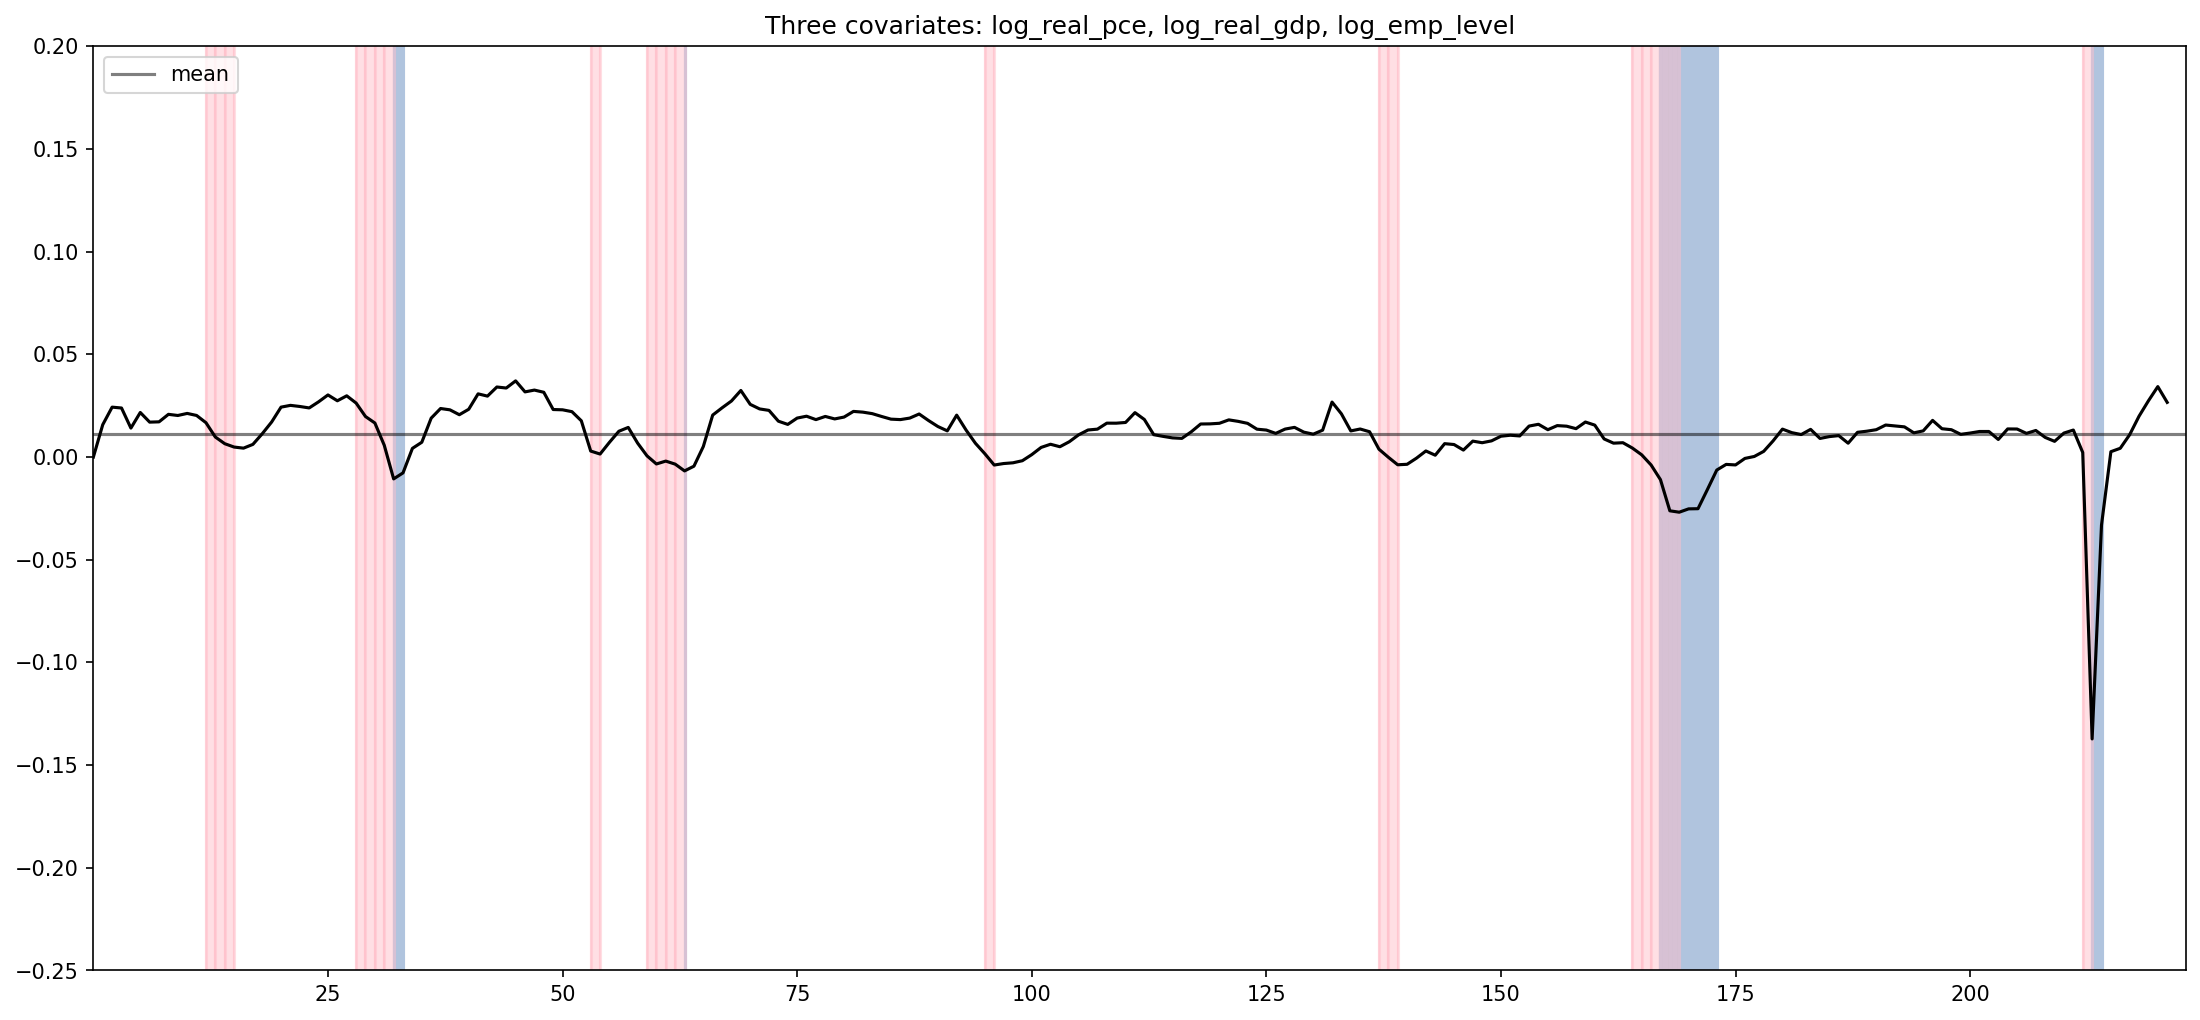

Our prediction is incorrect for approx. 16.6667 % of the time.


In [26]:
# TWO COVARIATES
twovars = df[['log_real_gdp', 'log_emp_level']]
twovars = twovars.to_numpy()
twovars = np.delete(twovars, 0, 1)
twovars = np.delete(twovars, 0, 0) 

G = np.ones((twovars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(twovars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_twovars = Kalman(x0, sigma0, rho, C, G, R, twovars)
k_twovars.plot_fig(title_name = "Three covariates: log_real_pce, log_real_gdp, log_emp_level", plot_rhat=True, gamma=1.12)
print('Our prediction is incorrect for approx.', np.round( k_twovars.calc_err(gamma=1.12)*100, 4), '% of the time.')


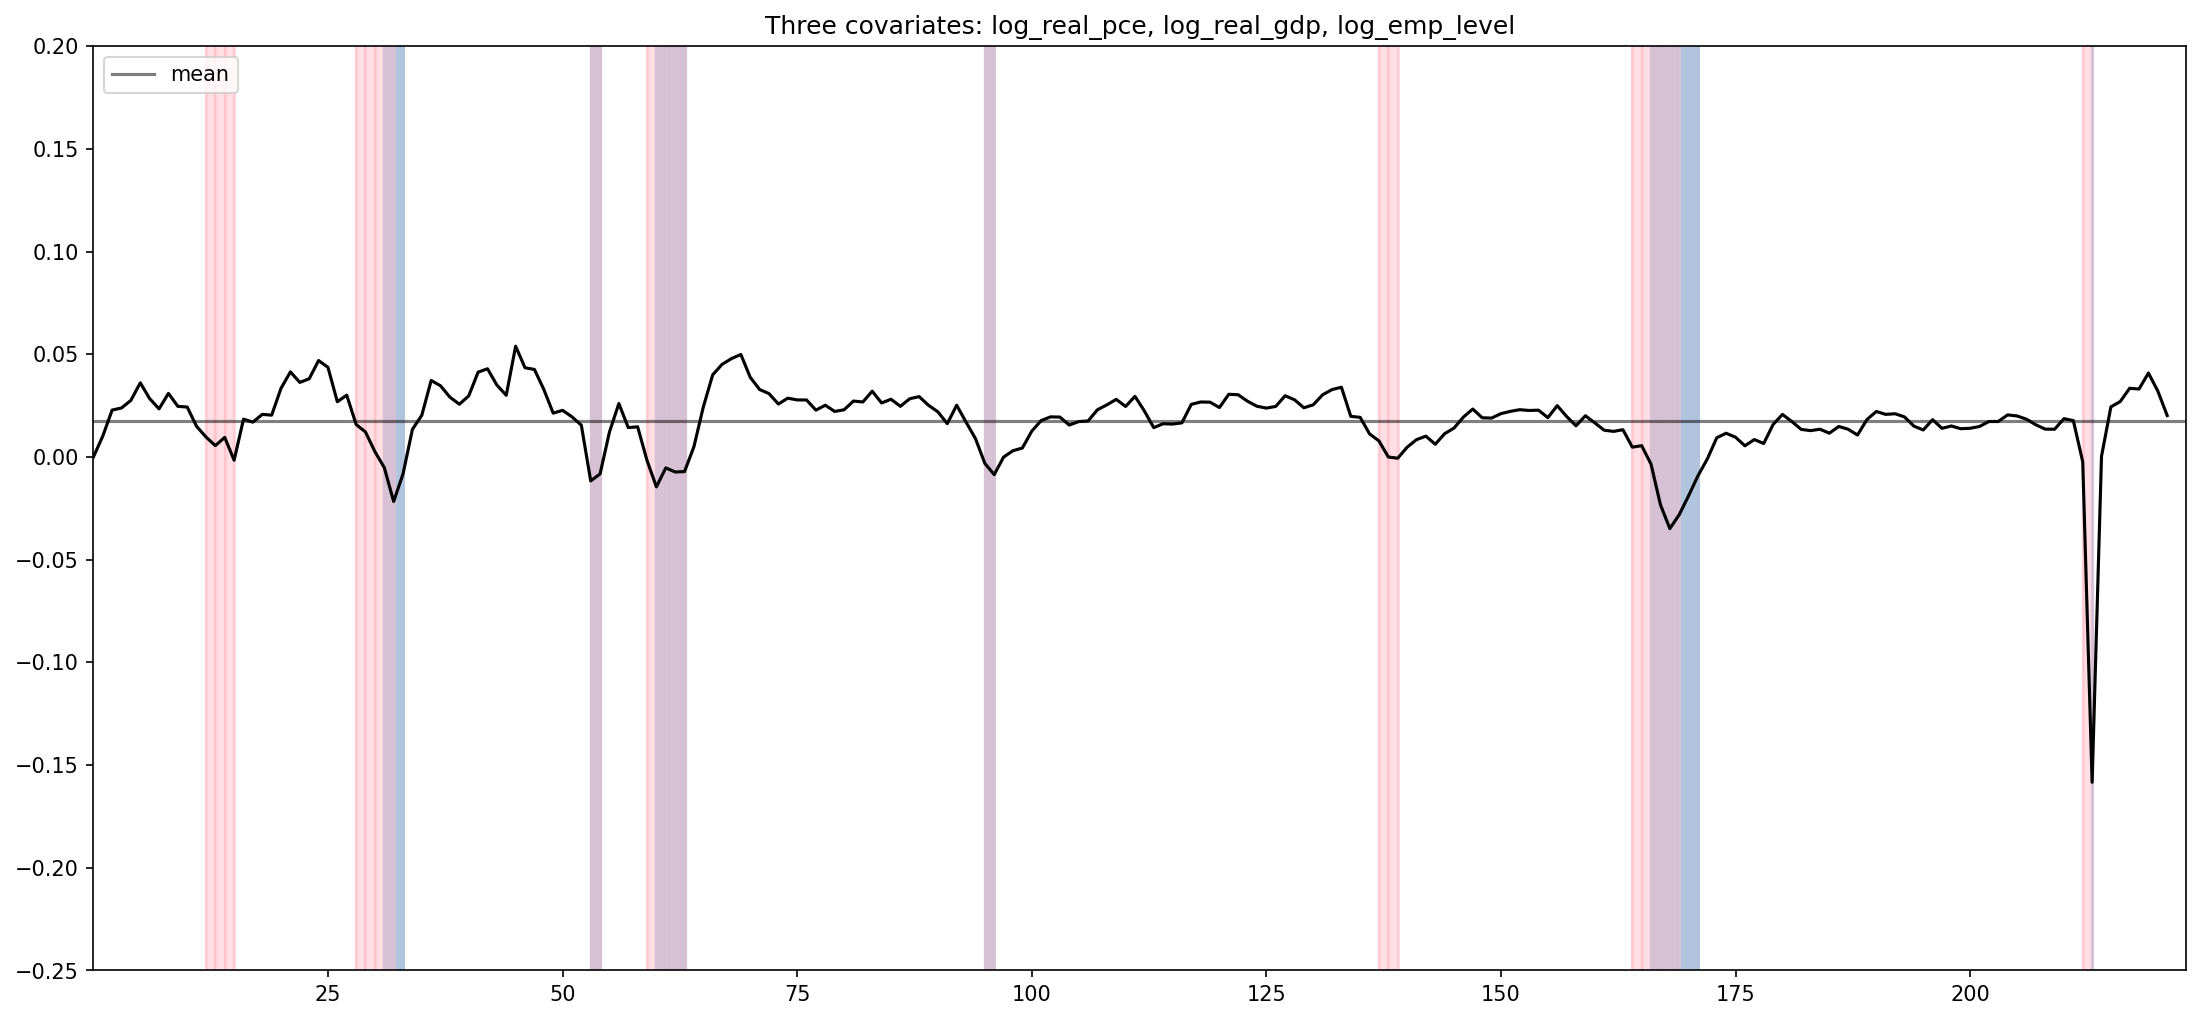

Our prediction is incorrect for approx. 13.0631 % of the time.


In [27]:
# THREE COVARIATES
threevars = df[['log_real_pce','log_real_gdp', 'log_emp_level']]
threevars = threevars.to_numpy()
threevars = np.delete(threevars, 0, 1)
threevars = np.delete(threevars, 0, 0) 

G = np.ones((threevars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(threevars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_threevars = Kalman(x0, sigma0, rho, C, G, R, threevars)
k_threevars.plot_fig(title_name = "Three covariates: log_real_pce, log_real_gdp, log_emp_level", plot_rhat=True, gamma=1.12)
print('Our prediction is incorrect for approx.', np.round( k_threevars.calc_err(gamma=1.12)*100, 4), '% of the time.')


In [28]:
# TRHREE COVS WITH NEW G,V
G = np.ones((threevars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(threevars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_threevars = Kalman(x0, sigma0, rho, C, G, R, threevars)

newG, newR = k_threevars.findG_cov(delta=15)
k_threevars = Kalman(x0, sigma0, rho, C, newG, newR, threevars)

# k_threevars.plot_fig(title_name = "Three covariates: log_real_pce, log_real_gdp, log_emp_level", plot_rhat=True, gamma=1.12)
print('Our prediction is incorrect for approx.', np.round( k_threevars.calc_err(gamma=1.12)*100, 4), '% of the time.')

k_threevars.rhat_fn(gamma=1.12).sum(), df['nber_recessions'][1:].to_numpy().sum()

Our prediction is incorrect for approx. 11.7117 % of the time.


(13.0, 29)

In [29]:
print(k_threevars.rhat_fn(gamma=1.12)[:106].sum(), df['nber_recessions'][:107].sum())
print(k_threevars.rhat_fn(gamma=1.12)[106:].sum(), df['nber_recessions'][107:].sum())

7.0 18
6.0 11


In [30]:
# Is R invertible
newR, np.linalg.inv(newR)

(array([[1.        , 0.        ],
        [0.        , 0.79351916]]),
 array([[1.        , 0.        ],
        [0.        , 1.26020902]]))

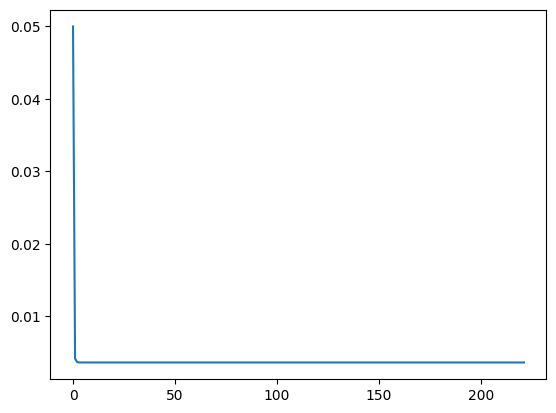

In [31]:
x3, sig3 = k_threevars.forecast()
plt.plot(sig3)
plt.show()

#### Four Covariates

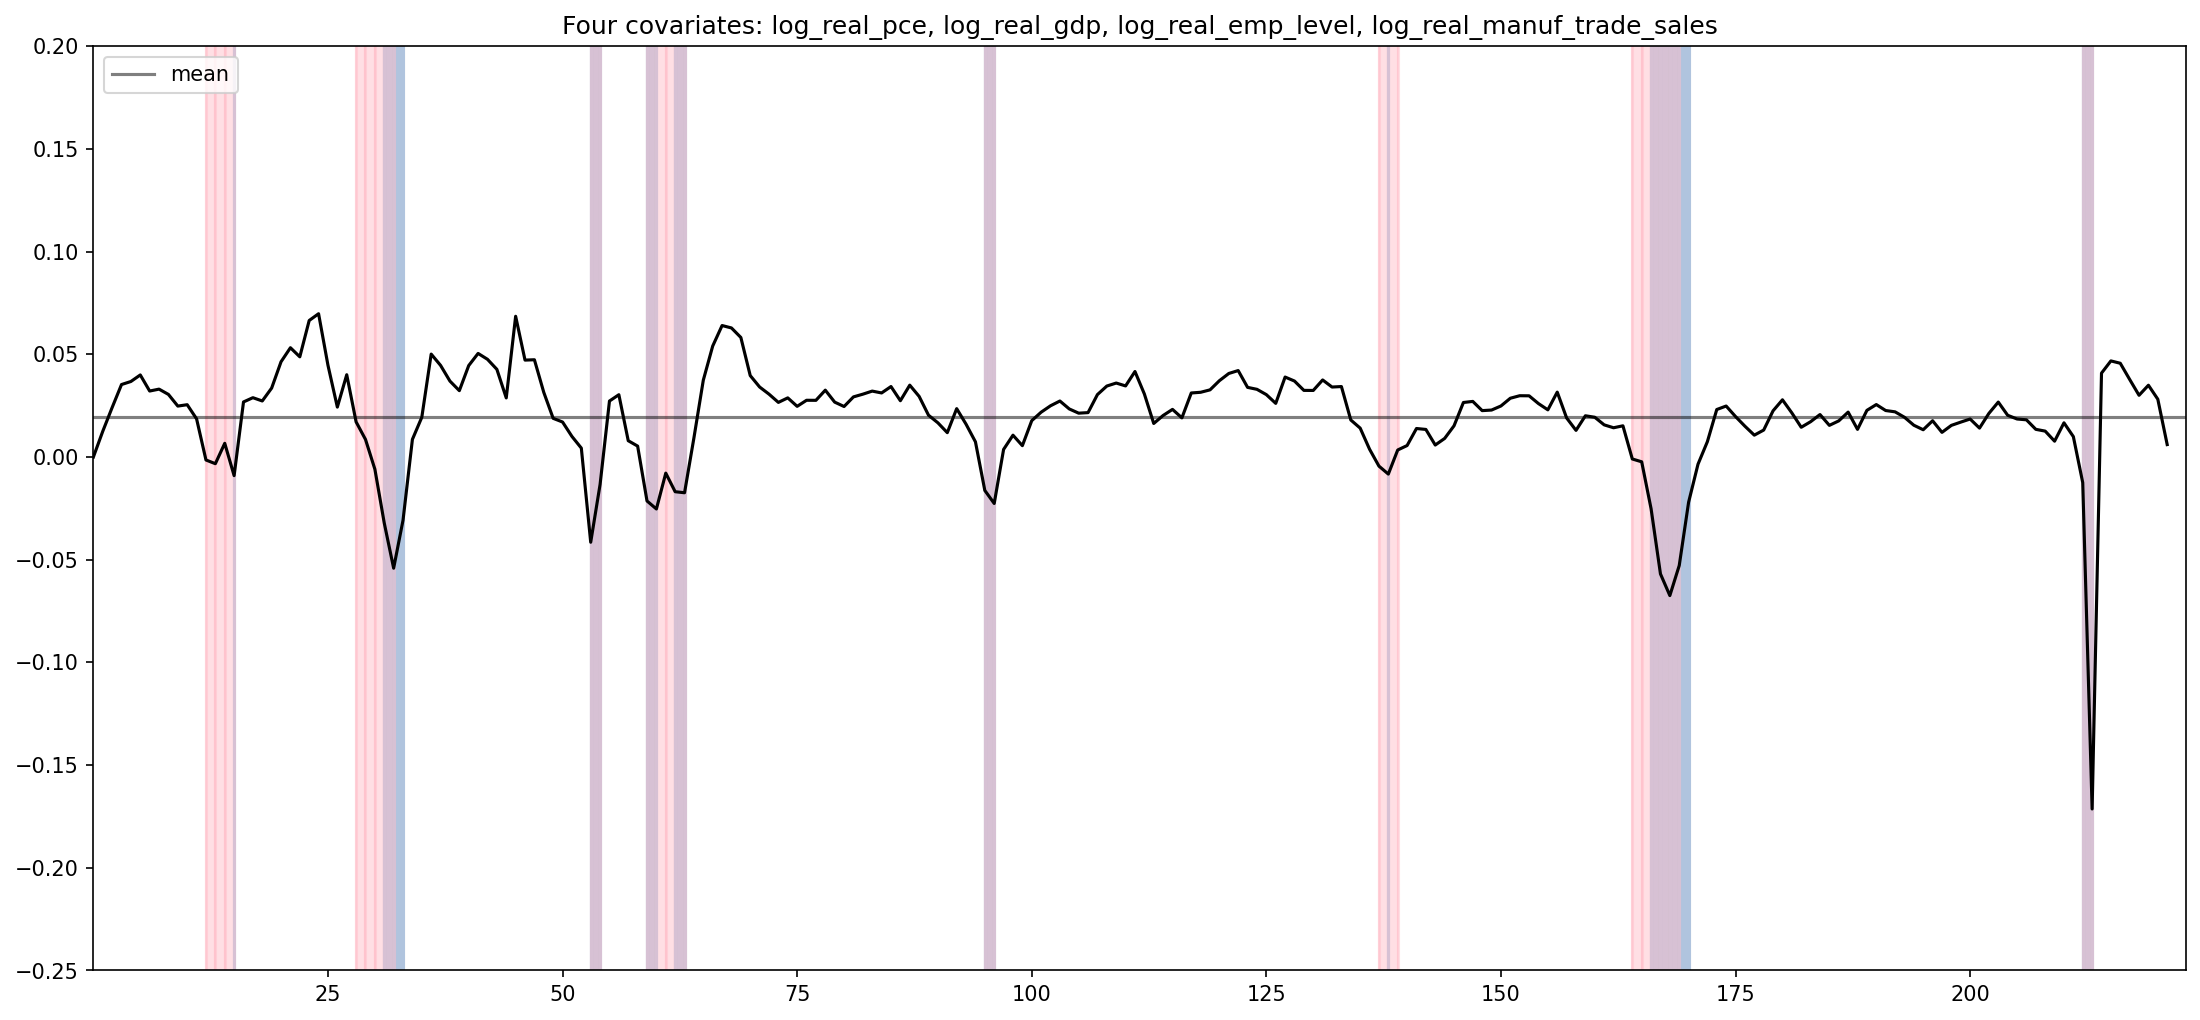

Our prediction is incorrect for approx. 12.1622 % of the time.


In [32]:
# FOUR COVARIATES
fourvars = df[['log_real_pce','log_real_gdp', 'log_emp_level', 'log_real_manuf_trade_sales']]
fourvars = fourvars.to_numpy()
fourvars = np.delete(fourvars, 0, 1)
fourvars = np.delete(fourvars, 0, 0) 

G = np.ones((fourvars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(fourvars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_fourvars = Kalman(x0, sigma0, rho, C, G, R, fourvars)
k_fourvars.plot_fig(title_name = "Four covariates: log_real_pce, log_real_gdp, log_real_emp_level, log_real_manuf_trade_sales", plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_fourvars.calc_err(gamma=1.12)*100, 4), '% of the time.')


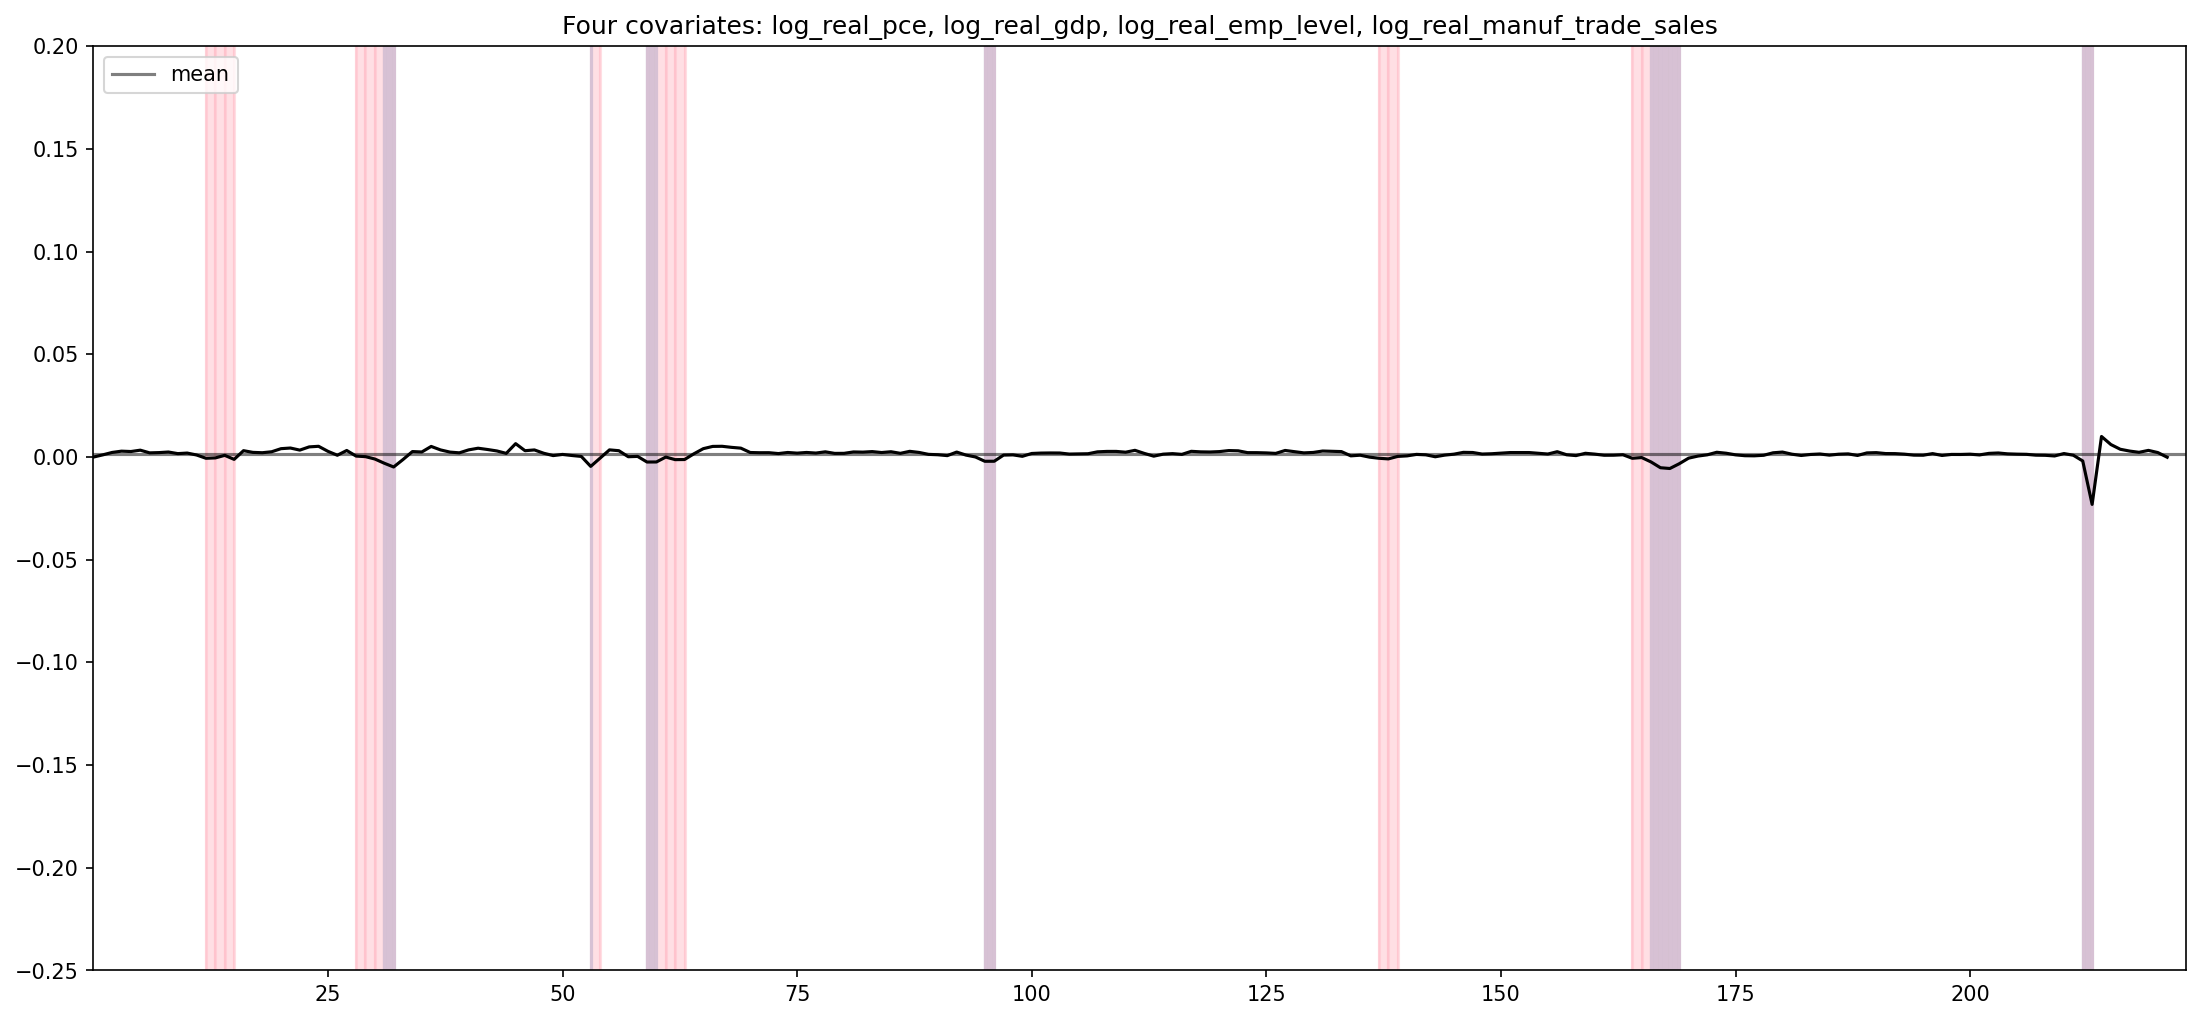

Our prediction is incorrect for approx. 10.8108 % of the time.


(13.0, 29)

In [33]:
# FOUR COVARIATES W NEW G,V
G = np.ones((fourvars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(fourvars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_fourvars = Kalman(x0, sigma0, rho, C, G, R, fourvars)

# newG, newR = k_fourvars.findG_cov(delta=4.5)
newG, newR = k_fourvars.findG_cov(delta=13)
k_fourvars = Kalman(x0, sigma0, rho, C, newG, newR, fourvars)

k_fourvars.plot_fig(title_name = "Four covariates: log_real_pce, log_real_gdp, log_real_emp_level, log_real_manuf_trade_sales", plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_fourvars.calc_err(gamma=1.12)*100, 4), '% of the time.')

k_fourvars.rhat_fn(gamma=1.12).sum(), df['nber_recessions'][1:].sum()


In [34]:
print(k_fourvars.rhat_fn(gamma=1.12)[:106].sum(), df['nber_recessions'][:107].sum())
print(k_fourvars.rhat_fn(gamma=1.12)[106:].sum(), df['nber_recessions'][107:].sum())

7.0 18
6.0 11


#### Five Covariates

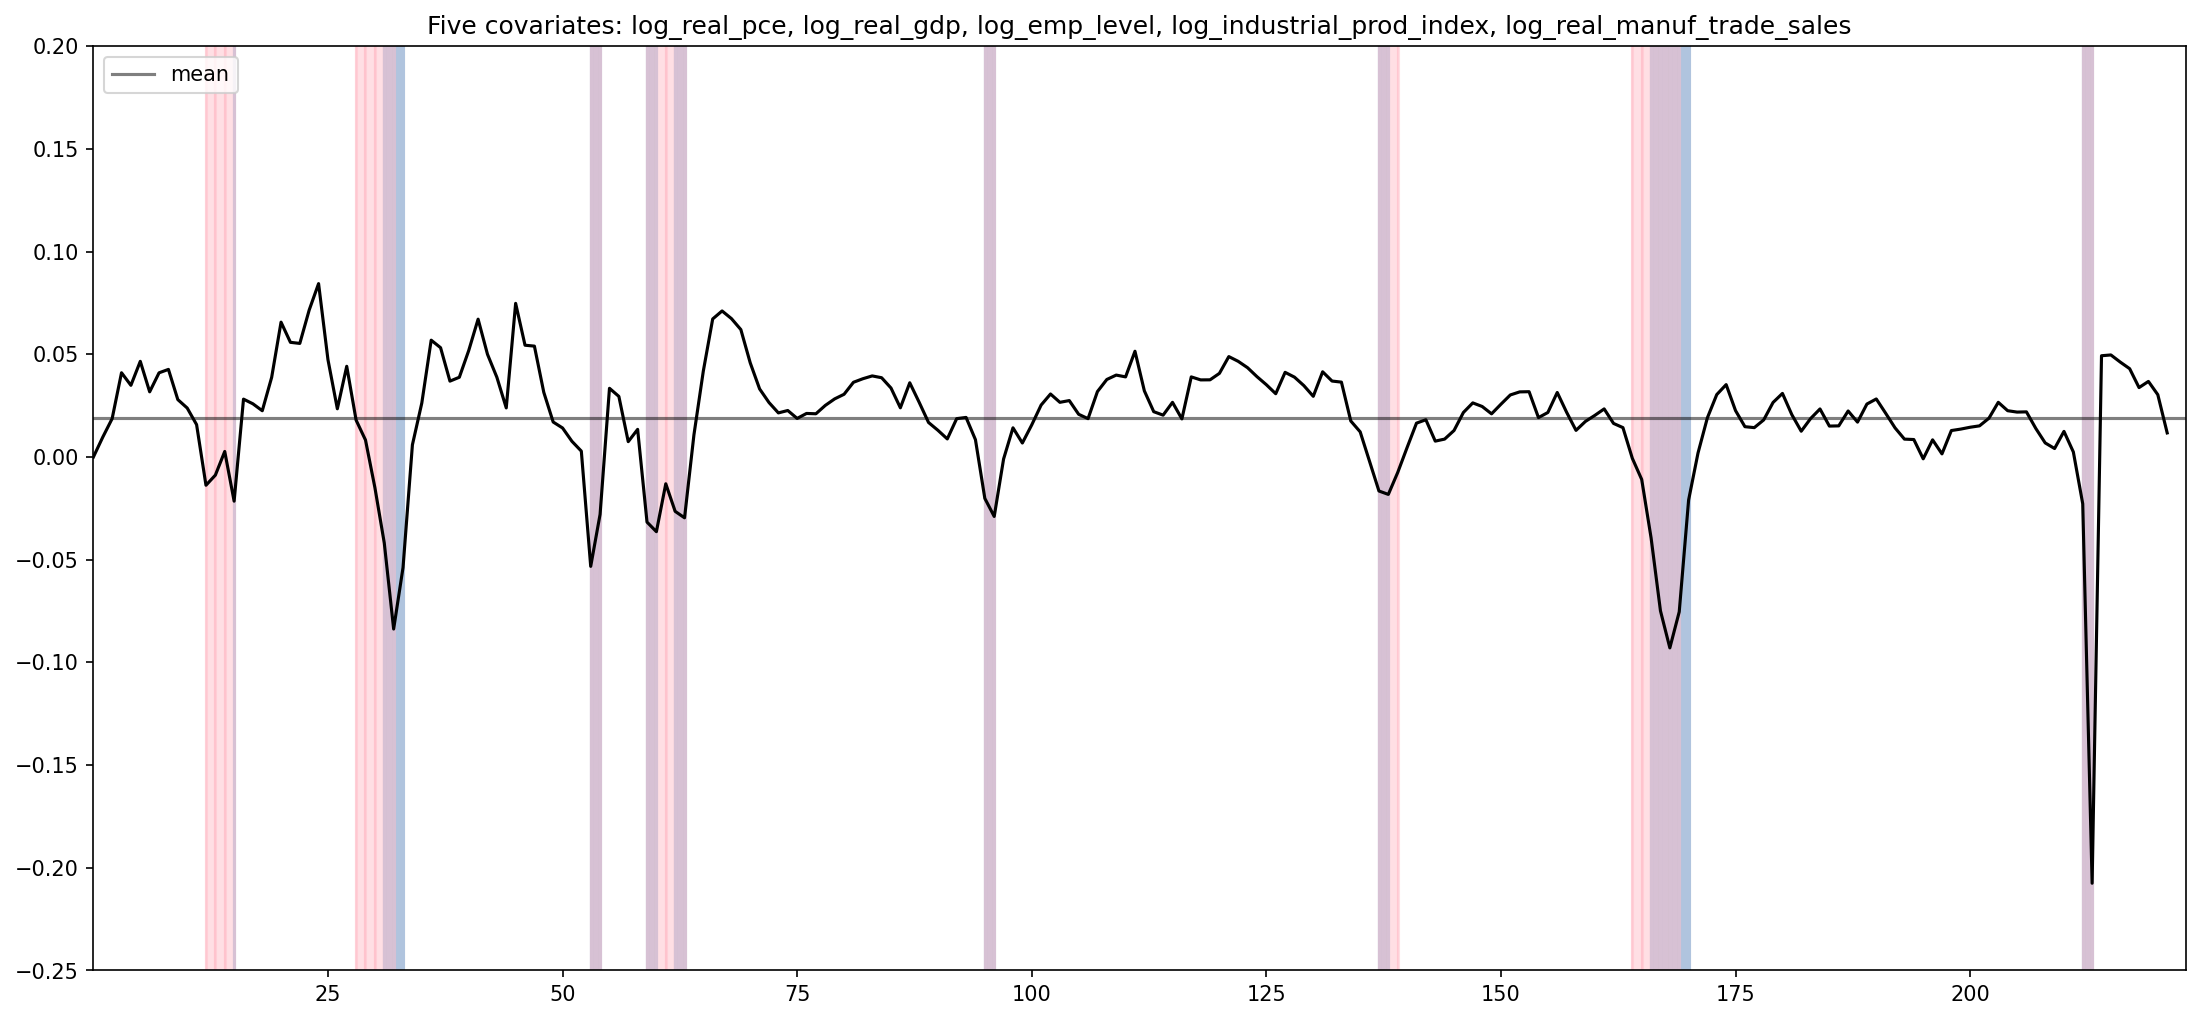

Our prediction is incorrect for approx. 11.7117 % of the time.


In [35]:
# FIVE COVARIATES
fivevars = df[['log_real_pce','log_real_gdp', 'log_emp_level', 
               'log_industrial_prod_index','log_real_manuf_trade_sales']]
fivevars = fivevars.to_numpy()
fivevars = np.delete(fivevars, 0, 1)
fivevars = np.delete(fivevars, 0, 0) 

G = np.ones((fivevars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(fivevars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_fivevars = Kalman(x0, sigma0, rho, C, G, R, fivevars)
k_fivevars.plot_fig(title_name = "Five covariates: log_real_pce, log_real_gdp, log_emp_level, log_industrial_prod_index, log_real_manuf_trade_sales", plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_fivevars.calc_err(gamma=1.12)*100, 4), '% of the time.')


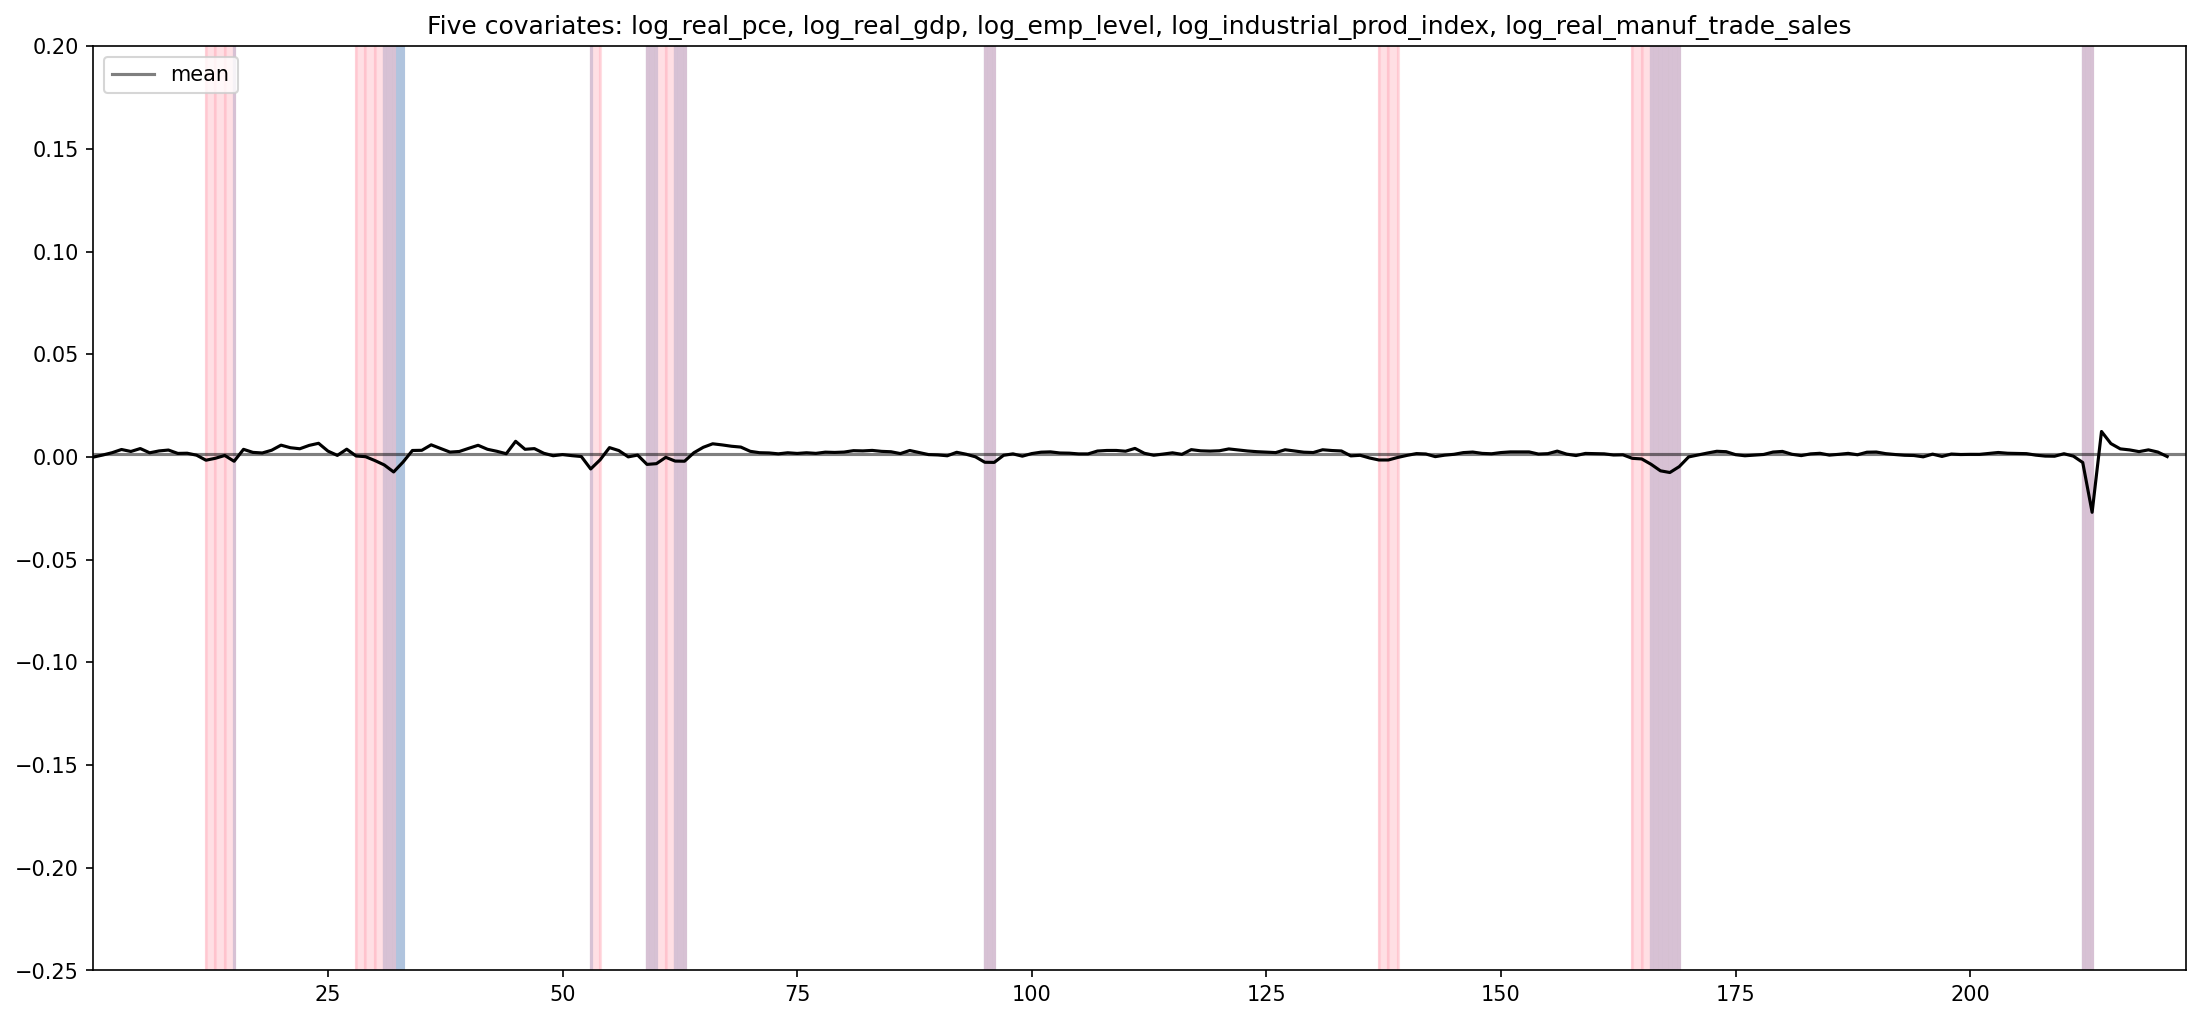

Our prediction is incorrect for approx. 11.7117 % of the time.


(17.0, 29)

In [36]:
# FIVE COVARIATES W NEW G, V
G = np.ones((fivevars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(fivevars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_fivevars = Kalman(x0, sigma0, rho, C, G, R, fivevars)

newG, newR = k_fivevars.findG_cov(delta=12)
k_fivevars = Kalman(x0, sigma0, rho, C, newG, newR, fivevars)

k_fivevars.plot_fig(title_name = "Five covariates: log_real_pce, log_real_gdp, log_emp_level, log_industrial_prod_index, log_real_manuf_trade_sales", plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_fivevars.calc_err(gamma=1.12)*100, 4), '% of the time.')

k_fivevars.rhat_fn(gamma=1.12).sum(), df['nber_recessions'][1:].sum()


In [37]:
print(k_fivevars.rhat_fn(gamma=1.12)[106:].sum(), df['nber_recessions'][107:].sum())
print(k_fivevars.rhat_fn(gamma=1.12)[:106].sum(), df['nber_recessions'][:107].sum())

6.0 11
11.0 18


#### Six covariates

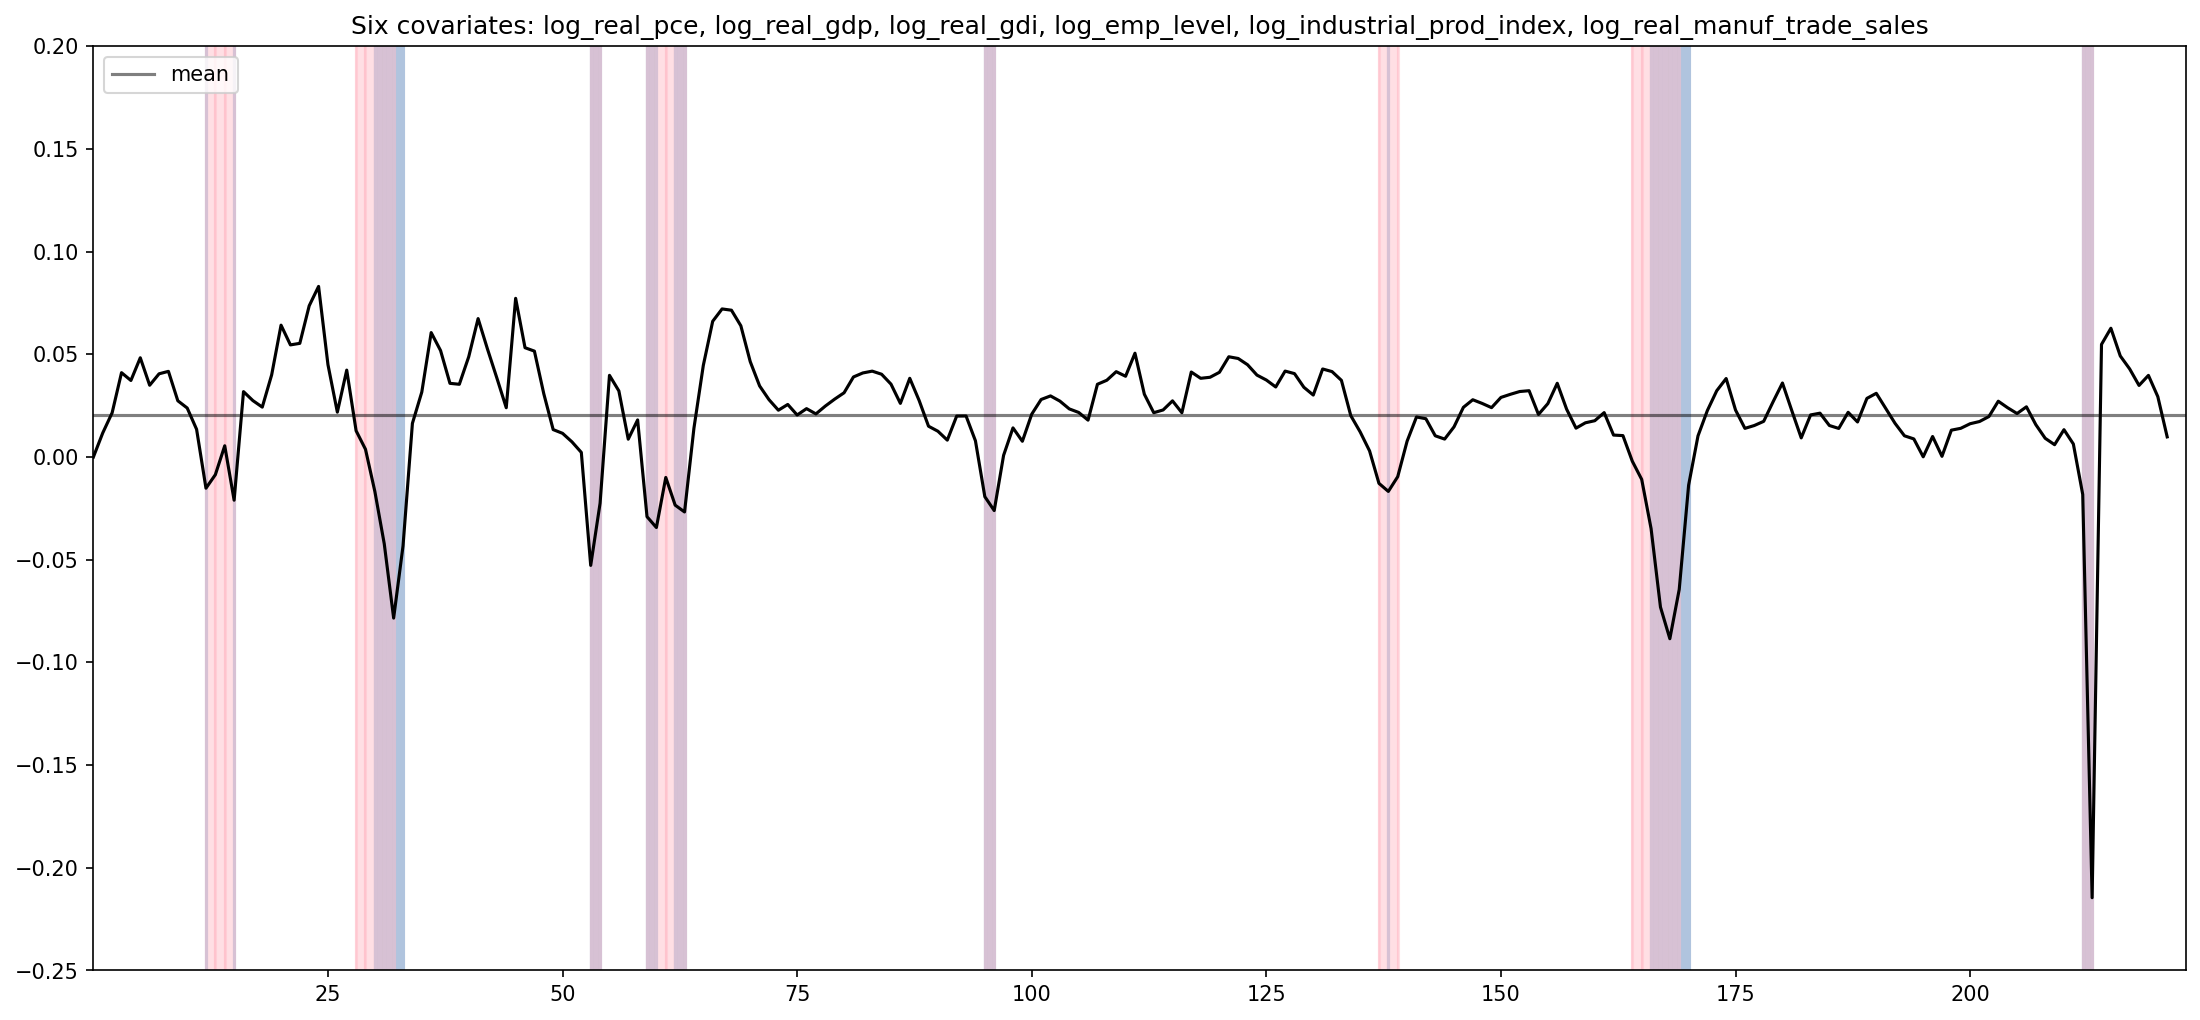

Our prediction is incorrect for approx. 11.2613 % of the time.


In [38]:
# SIX COVARIATES
sixvars = df[['log_real_pce','log_real_gdp', 'log_real_gdi', 'log_emp_level', 'log_industrial_prod_index',
               'log_real_manuf_trade_sales']]
sixvars = sixvars.to_numpy()
sixvars = np.delete(sixvars, 0, 1)
sixvars = np.delete(sixvars, 0, 0) 

G = np.ones((sixvars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(sixvars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_sixvars = Kalman(x0, sigma0, rho, C, G, R, sixvars)
k_sixvars.plot_fig(title_name = "Six covariates: log_real_pce, log_real_gdp, log_real_gdi, log_emp_level, log_industrial_prod_index, log_real_manuf_trade_sales", plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_sixvars.calc_err(gamma=1.12)*100, 4), '% of the time.')


### All Covariates

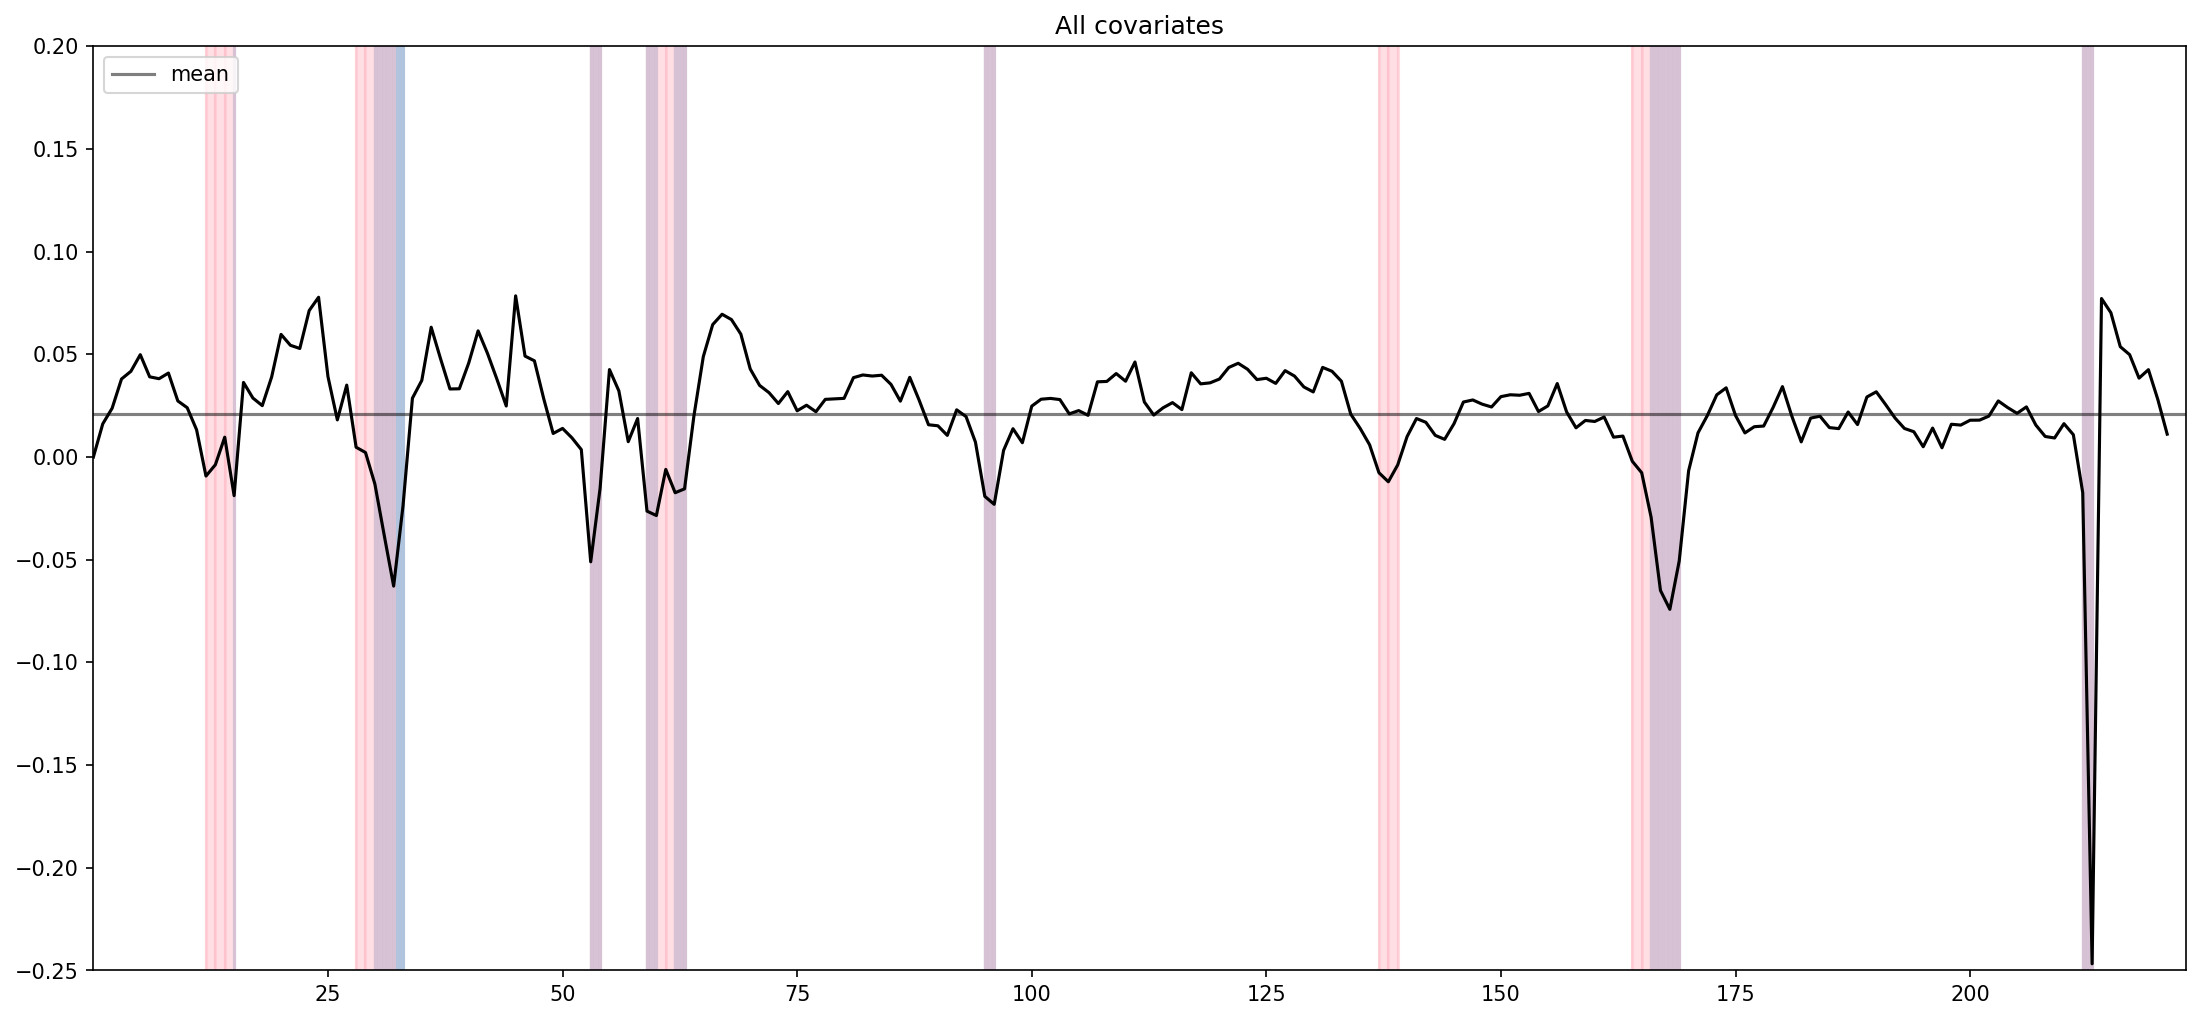

Our prediction is incorrect for approx. 11.7117 % of the time.


In [39]:
# ALL COVARIATES (9)
allvars = df[['log_real_personal_income_less_transfers', 'log_real_pce',
       'log_real_gdp', 'log_real_gdi', 'log_real_avg_gdp_gdi',
       'log_total_nonfarm_emp', 'log_emp_level', 'log_industrial_prod_index',
       'log_real_manuf_trade_sales']]
allvars = allvars.to_numpy()
allvars = np.delete(allvars, 0, 1)
allvars = np.delete(allvars, 0, 0) # First row NaNs!

G = np.ones((allvars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(allvars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_allvars = Kalman(x0, sigma0, rho, C, G, R, allvars)
k_allvars.plot_fig(title_name = 'All covariates' ,plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_allvars.calc_err(gamma=1.12)*100, 4), '% of the time.')


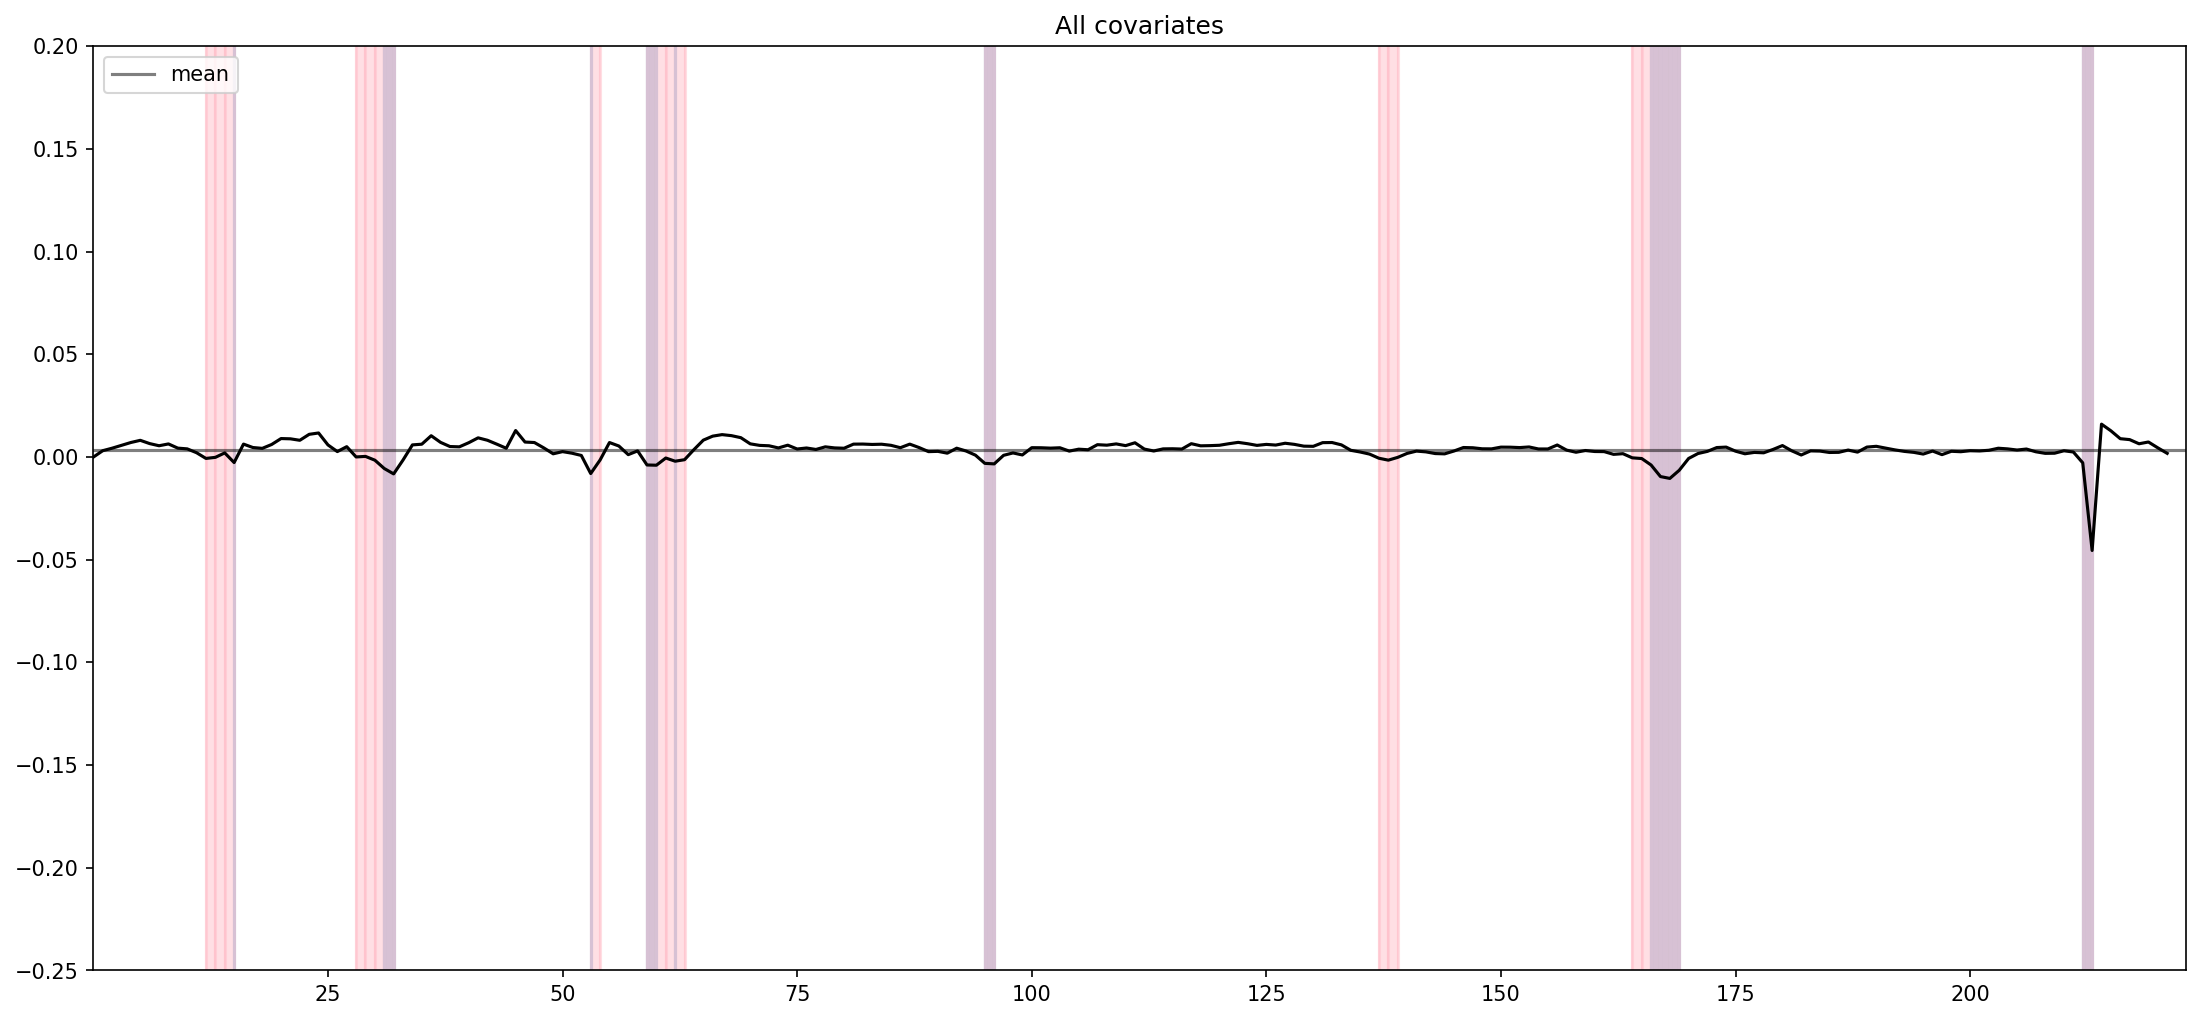

Our prediction is incorrect for approx. 10.8108 % of the time.


(15.0, 29)

In [40]:
# ALL COVARIATES W NEW G,V
G = np.ones((allvars.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(allvars.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

k_allvars = Kalman(x0, sigma0, rho, C, G, R, allvars)

# newG, newR = k_allvars.findG_cov(delta=2)
# newG, newR = k_allvars.findG_cov(delta=20)
newG, newR = k_allvars.findG_cov(delta=6)

k_allvars = Kalman(x0, sigma0, rho, C, newG, newR, allvars)
k_allvars.plot_fig(title_name = 'All covariates', plot_rhat=True, gamma=1.12)

print('Our prediction is incorrect for approx.', np.round( k_allvars.calc_err(gamma=1.12)*100, 4), '% of the time.')

k_allvars.rhat_fn(gamma=1.12).sum(), df['nber_recessions'][1:].sum()


In [41]:
print(k_allvars.rhat_fn(gamma=1.12)[:106].sum(), df['nber_recessions'][:107].sum())
print(k_allvars.rhat_fn(gamma=1.12)[106:].sum(), df['nber_recessions'][107:].sum())

9.0 18
6.0 11


Start with one variable for $y = Gx + \nu$ then change for another variable and then once what the code is doing is sensible, add more variables and start adjusting parameters

Misclassification search; search over the parameters wrt what $\hat{r}_t$'s they yield and use optimizer to pick the best one

## Next Steps: 
1. Using the error method ``calc_err`` for a fixed $\gamma$, loop through different choices of (logged) covariates from our initial dataframe, and choose covariate subset (which may the entire set) with the least total error (``np.sum(calc_err)``).
2. Choose optimal $\gamma$ by doing similar procedure with fixed set of covariates.
3. Choose optimal parameter calibration by doing similar procedure, keeping in mind the following: 
- General rule of thumb (from Jarda): (i) Higher $\sigma$, aka $C$, should correspond with a lower threshold $R$ (lower $\gamma$); (ii) Larger $[G]_{i}$ should correspond with lower $[R]_{ii}$, where $i$ denotes the $i$th covariate out of $K$ covariates, and vice versa. -- encoded in adam's addition of the std deviation thing
- Inverse relationship between $[G]_{i}$ and $[R]_{ii}$, i.e. (the $(i,i)$th component of the variance-covariance matrix for $\nu_t$ aka the $\mathbb{V}(y_t^{(i)})$ for $i \in \{1,...,K\}$, reflects how a covariate with more signal (more information) should also have less noise (less meaningless bits). 
- For the first comment about $C$ and threshold $R$, Jarda told me that we would discover this; I think this makes sense, since $C$ is the variance for $w_{t+1}$, and higher $C$ means that the unobservstate is harder to 
4. 